# RDBMS - MySQL 

## 00 - Introduction

Among the Relational DBMSs, the most widely known are Oracle, SQLite, Postgress, MariaDB, MySQL.

Each one of them is characterized by a different set of "variations" on top of the base SQL language, although usually minor.

We will use **MySQL** to run exercises about Relational DB transactions using the SQL language, as it is *today* at the top of the list of most widely used RDBs. 

https://db-engines.com/en/ranking_trend/relational+dbms

https://www.statista.com/statistics/809750/worldwide-popularity-ranking-database-management-systems/

https://insights.stackoverflow.com/survey/2021#most-popular-technologies-database

MySQL programming interfaces exist for many languages, including C, C++, Go, Java, Perl, PHP, Python, etc...

Even simply referring to Python, we can count on several options to connect and interact with the DBs. 

Let's explore a couple of them...

## 01 - Create a connection to MySQL 

A MySQL server is in execution on one of your Docker containers.

We can access it via the MySQL server credential we have defined in the docker-compose yml.

A `root` user is created by default with:
- user: `root`
- password: `root_pwd`

A non-`root` user is also created by default with:
- user: `my_user`
- password: `my_pwd`

#### Interactive 

We can interact with the MySQL server by logging in interactively to its docker container.

Check the `CONTAINER ID` of the container named `mysql_db` via:
    
```bash 
$ docker ps 
```

And run `bash` (or `/bin/bash`) in interactive mode attaching it to the terminal (`-it`) on the container:

```bash
$ docker exec -it <YOUR CONTAINER ID> bash
```

From inside the container we can use the RDBMS interface as if we were logged into a remote MySQL server hosting our DBs

```bash
$ mysql -u <EITHER ROOT OR USER> -p
``` 

We can then inspect the MySQL server to show us all DBs:
    
```mysql
SHOW DATABASES;
```

_NB_: remember to end a SQL command with a semicolon `;`

#### mysql.connector

A more pythonic way of communicating with a MySQL server is by using a dedicated driver.

We will use `mysql.connector`, which has already been installed in the Jupyter-notebook container for you.

The connector offers an interface to declare a connection object to the server, and provides a series of functionalities to issue transactions and fetch records from DBs.

We start by declaring a connection to our MySQL server.

_NB_: the server is hosted in a different container from the notebook... we are simulating a connection between two differen machines, a client and a server.

In [1]:
# import the connector
import mysql.connector

# declare a connection to the MySQL server 
# the hostname (or IP) of the server machine should be passed
db = mysql.connector.connect(
  user="root",
  password="root_pwd",
  host="db", # in this case 'db' is the equivalent of the IP address of the server 
             # or 'localhost' if running mysql locally
)

print(db)

At this point a DB connection is enstablished

To interact with the DB via python and mysql.connector we need a "handle", known as a cursor, which has to be instantiated.

Using this connector to interact with the DB, all SQL statements are executed using the cursor.

In [2]:
# create our db cursor object
dbc = db.cursor()

The cursor allows to execute all SQL transactions on the DB as if we were logged into the server.

If a transaction will fetch a result from the DB (a set of records are returned), the connector object will retain the results.

This might come in handy for us to use it in a more "pythonic" way later on, interfacing our DB query with other Python statements.

The syntax for issuing a generic SQL statement is the following:

```python
connector_object.execute(my_sql_query)
```

For instance, let's try to execute the same check as before, by asking MySQL to show us all available DBs...

In [3]:
# show all available databases
dbc.execute(
"SHOW DATABASES"
)

No output is printed as the result of this SQL transaction is in fact "collected" into the cursor as a list of records (tuples).

We can simply loop over them to return the results.

In [4]:
# loop over the container to fetch the results
for _ in dbc:
    print(_)

('information_schema',)
('mysql',)
('performance_schema',)
('sys',)


If we are `root` users in this example, we are able to see inner structure of the mysql server, which already contains a few dbs by default. 

Once fetched the output of the transaction, the cursor reaches "the end" of the records, and is available to perform a new transaction

In [5]:
# use fetch to retrieve one, many, or all entries in the cursor
dbc.fetchone()

# dbc.fetchmany(2)

# dbc.fetchall()

In the case one wants to perform a new transaction without collecting the output of the previos one from the cursor, a reset have to be issued first:

```python 
connector_object.reset()
```


In the case a generic user is instead logged into the db (i.e. non the `root` user), it will not have access to a set of functionalities, and will not be able to see the previous list of all databases.

Some of those are in fact protected and used to store additional information on the state of the MySQL server, the users connected, ...

In [6]:
udb = mysql.connector.connect(
  user="my_user",
  password="my_pwd",
  host="db",
)

udbc = udb.cursor()

udbc.execute(
"SHOW DATABASES"
)

udbc.fetchall()

[('information_schema',), ('performance_schema',)]

#### iPython magic

An alternative way to perform queries from Python over a Jupyter-notebook is by using some notebook "magic", based on iPython and SQLAlchemy.

This is a similar thing to what is usually done to load inline a figure from matplotlib (the `%matplotlib inline` thingy).

To instruct iPython to interpret SQL commands, and to connect to the proper DB we have to: 
1. load the extension for SQL language
2. set the environment variable to point to the connection to the DB

In [3]:
%load_ext sql

%env DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db

env: DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db


Now, the notebooks cells can perform SQL transactions directly in plain SQL, by starting the cell with `%%sql`.

By default, the result is also printed with the `pretty` pandas-like format.

In [8]:
%%sql

SHOW DATABASES;

4 rows affected.


[('information_schema',), ('mysql',), ('performance_schema',), ('sys',)]

An additional benefit is that a single `%slq` (not a double `%%sql`) can be used to join a SQL query with any Python command

In [9]:
my_python_var = %sql SHOW DATABASES

print(my_python_var)

 * mysql+mysqlconnector://root:***@db
4 rows affected.
+--------------------+
|      Database      |
+--------------------+
| information_schema |
|       mysql        |
| performance_schema |
|        sys         |
+--------------------+


The combination of either of the two pythonic methods can be used to easily redirect the output of DB transactions to exploit all other well-known python modules, e.g. plotting with matplotlib

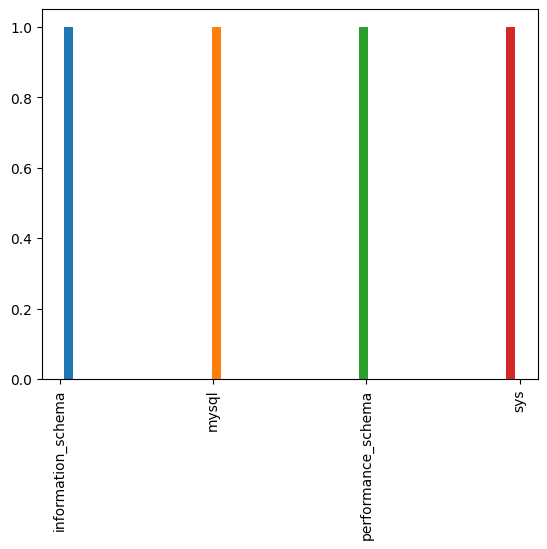

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(my_python_var);
plt.xticks(rotation='vertical');

## 02 Database and Table creation

We have already seen how we inspect the server to see which DBs are present via the command:

```mysql
SHOW DATABASES;
```

We can start interacting with a specific DB by selecting which one to use via 

```mysql
USE <DB_NAME>;
```

If instead we want to create a new DB to work with, we can use the command

```mysql
CREATE DATABASE <DB_NAME>;
```

A more complex sintax can be used to create a new DB if and only if no other DB with the same name already exists.

```mysql
CREATE DATABASE IF NOT EXISTS <DB_NAME>;
```

If the user has been granted the right to access this DB, it's possible to start investigating the content of the DB in use.

Check if a DB named `my_db` exist, and if not, create one. 
Then, switch to the new DB to start using it.

In [11]:
%%sql

CREATE DATABASE IF NOT EXISTS my_db;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [12]:
%%sql

SHOW DATABASES;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('information_schema',),
 ('my_db',),
 ('mysql',),
 ('performance_schema',),
 ('sys',)]

In [13]:
%%sql

USE my_db;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

All tables contained in the DB are shown in a similar way to what used to show all DBs on the server:

```mysql
SHOW TABLES;
```

_NB_: we are inspecting the content of a specific DB (the one selected with `USE <DB_NAME>`)

In [14]:
%%sql 

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

The analogous pythonic way to execute the same list of commands (using the mysql.connector driver) is the following.

_NB_: This time, as we are not retrieving results from the server but we are instead creating a DB, we have to specify that we want to _commit_ a change to the server; 

In [15]:
# defining the sql command line
sql_ = "CREATE DATABASE IF NOT EXISTS my_db;"

# instructing the cursor to execute it
dbc.execute(sql_)

# in this case the result of the sql transaction is not to return a list of items 
# it is instead a change in the DB structure
# therefore, for the change to have effect, a the change is to be committed to the DB
db.commit() 

All other commands, `USE` and `SHOW`, do not require any change to be committed, therefore we can simply issue them via the cursor.

In [16]:
dbc.execute("USE my_db")

dbc.execute("SHOW TABLES")
dbc.fetchall()

[]

So far the DB is empty, so let's use the same lines presented in the slides to create a dummy `Users` table.

Any table can then be inspected to check its schema by listing all attributes.

1. Create the `Users` table declaring the schema by defining each attributes
2. Check if the table has been created on the DB via a `SHOW` command
3. Check the Table schema by issuing `DESCRIBE <TABLE_NAME>`

In [17]:
%%sql

CREATE TABLE Users (
    UserID varchar(30),
    BadgeNum int(16),
    FirstName varchar(255),
    LastName varchar(255),
    Age int,
    OtherAttr float
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [18]:
%%sql 

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[('Users',)]

In [19]:
%%sql

DESCRIBE Users;

 * mysql+mysqlconnector://root:***@db
6 rows affected.


[('UserID', b'varchar(30)', 'YES', '', None, ''),
 ('BadgeNum', b'int', 'YES', '', None, ''),
 ('FirstName', b'varchar(255)', 'YES', '', None, ''),
 ('LastName', b'varchar(255)', 'YES', '', None, ''),
 ('Age', b'int', 'YES', '', None, ''),
 ('OtherAttr', b'float', 'YES', '', None, '')]

Following on the lines of the previous examples, perform the same transactions with the `mysql.connector` driver.

This time, as the `Users` table already exists, we can create a `Users_py` table.

Remember:
- Use the DB Cursor to execute the transactions
- Transaction that change the content of the DB have to be _committed_ to the DB
- Transactions returing the content of the DB host their results _in the cursor_

In [20]:
dbc.reset() #che cosa fa?

In [21]:
# create table
sql_ = "CREATE TABLE Users_py (\
    UserID varchar(30),\
    BadgeNum int(16),\
    FirstName varchar(255),\
    LastName varchar(255),\
    Age int,\
    OtherAttr float\
);"

dbc.execute(sql_)

db.commit()

In [22]:
dbc.execute("SHOW TABLES")

In [23]:
dbc.fetchall()

[('Users',), ('Users_py',)]

In [24]:
# describe table
dbc.execute("DESCRIBE Users_py")

In [25]:
dbc.fetchall()

[('UserID', b'varchar(30)', 'YES', '', None, ''),
 ('BadgeNum', b'int', 'YES', '', None, ''),
 ('FirstName', b'varchar(255)', 'YES', '', None, ''),
 ('LastName', b'varchar(255)', 'YES', '', None, ''),
 ('Age', b'int', 'YES', '', None, ''),
 ('OtherAttr', b'float', 'YES', '', None, '')]

## 03 Declaring contstraints and altering tables

Let's clean up all existing tables in our database.

To remove an existing table from a DB we can issue the instruction:
    
```mysql
DROP TABLE IF EXISTS <NAME OF YOUR TABLE>;
```

Be ***extremely careful*** when doing this... Dropping a Table means losing all records from that table, and severing all connections with other tables based on foreign keys. The entire DB might become unusable!


In [26]:
%%sql 

DROP TABLE IF EXISTS Users;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

Let's also drop the `Users_py` table using the Python connetor

In [27]:
dbc.execute("DROP TABLE IF EXISTS Users_py")
db.commit()

Create a new `products` table with the following schema:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |

`productID` will also be our `PRIMARY KEY`

This can be declared either inline or at the end of the table definition:

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY
```

or 

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT
...
PRIMARY KEY (productID)
```

In [28]:
%%sql

CREATE TABLE IF NOT EXISTS products (
         productID    INT          NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
         productName  VARCHAR(30)  DEFAULT "" ,
         unitPrice    FLOAT        NOT NULL DEFAULT 99999.99,
         unitsInStock INT UNSIGNED NOT NULL DEFAULT 0
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [29]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[('productID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('productName', b'varchar(30)', 'YES', '', b'', ''),
 ('unitPrice', b'float', 'NO', '', b'100000', ''),
 ('unitsInStock', b'int unsigned', 'NO', '', b'0', '')]

The table does not contain any constraint, default values, or keys.

A table can be altered by adding/removing Attributes, as well as by adding constraints.

Let's first add a new attribute to the table:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| **isDiscontinued**  | **Bool** | | NOT NULL |

To alter a table and create a new column we can act on it with:

```mysql
ALTER TABLE <THE TABLE>
ADD COLUMN <NEW COL> <THE NEW ATTRIBUTE DECLARATION>;
```


Alter the `products` table and add the `isDiscontinued` attribute

In [30]:
%%sql

ALTER TABLE products
ADD COLUMN isDiscontinued BOOL NOT NULL;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [31]:
%%sql 

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('productID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('productName', b'varchar(30)', 'YES', '', b'', ''),
 ('unitPrice', b'float', 'NO', '', b'100000', ''),
 ('unitsInStock', b'int unsigned', 'NO', '', b'0', ''),
 ('isDiscontinued', b'tinyint(1)', 'NO', '', None, '')]

`isDiscontinued` does however not contain any meaningful constraint or default value.
Let's consider `0` as a good default value:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL **DEFAULT 0** |


We can use the same `ALTER TABLE` instruction to do this:
    
```mysql
ALTER TABLE <THE TABLE>
ALTER <ATTRIBUTE> SET DEFAULT <NEW DEFAULT>;
```

In [32]:
%%sql

ALTER TABLE products
ALTER isDiscontinued SET DEFAULT 0;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [33]:
%%sql 

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('productID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('productName', b'varchar(30)', 'YES', '', b'', ''),
 ('unitPrice', b'float', 'NO', '', b'100000', ''),
 ('unitsInStock', b'int unsigned', 'NO', '', b'0', ''),
 ('isDiscontinued', b'tinyint(1)', 'NO', '', b'0', '')]

We can also impose `productName` to be not-null altering the table one final time.

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | **NOT NULL** DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL DEFAULT 0 |


In MySQL, this implies to modify the entire attribute, thus the Type will have to be re-stated:
    
```mysql
ALTER TABLE <THE TABLE>
MODIFY <ATTRIBUTE> <ATTRIBUTE TYPE> <CONSTRAINT>;
```

In [34]:
%%sql

ALTER TABLE products
MODIFY productName VARCHAR(30) NOT NULL DEFAULT "";

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [35]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('productID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('productName', b'varchar(30)', 'NO', '', b'', ''),
 ('unitPrice', b'float', 'NO', '', b'100000', ''),
 ('unitsInStock', b'int unsigned', 'NO', '', b'0', ''),
 ('isDiscontinued', b'tinyint(1)', 'NO', '', b'0', '')]

Let's now create a `suppliers` table with the following description:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| supplierID   | Integer | | NOT NULL AUTO_INCREMENT |
| supplierName | String | Max length 30 | NOT NULL DEFAULT "" |
| countryCode   | Char | Length 3 | NOT NULL |
| email   | String | Max length 30  | NOT NULL |

`supplierID` is going to act as the table's primary key in this case.

In [36]:
%%sql

CREATE TABLE suppliers (
    supplierID      INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
    supplierName    VARCHAR(30) NOT NULL DEFAULT "",
    countryCode     CHAR(3) NOT NULL,
    email           VARCHAR(30) NOT NULL
);


 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [37]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[('supplierID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('supplierName', b'varchar(30)', 'NO', '', b'', ''),
 ('countryCode', b'char(3)', 'NO', '', None, ''),
 ('email', b'varchar(30)', 'NO', '', None, '')]

Alter the table to include a default "ITA" for `countryCode`

In [38]:
%%sql 

ALTER TABLE suppliers 
ALTER countryCode SET DEFAULT "ITA";

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [39]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[('supplierID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('supplierName', b'varchar(30)', 'NO', '', b'', ''),
 ('countryCode', b'char(3)', 'NO', '', b'ITA', ''),
 ('email', b'varchar(30)', 'NO', '', None, '')]

In [40]:
%%sql

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('products',), ('suppliers',)]

To enstablish a relation between the `products` and `suppliers` tables, we have to consider that:
    
- a supplier can supply multiple products
- a product can be supplied by multiple suppliers

This is a many-to-many relationship, which requires a supporting external table.

Create a new `supplier_to_product` table with the following attributes:
    
| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| prodID   | Integer | | NOT NULL |
| supID    | Integer | | NOT NULL |


In [41]:
%%sql 

CREATE TABLE supplier_to_product(
    prodID INT NOT NULL,
    supID  INT NOT NULL
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [42]:
%%sql 

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('prodID', b'int', 'NO', '', None, ''), ('supID', b'int', 'NO', '', None, '')]

Neither prodID nor supID is a good primary key in this case, as we can have both appearing multiple times in the table.

However, a good primary key for this table is the combination (prodID,supID) which is absolutely unique, and thus, a good key.

We can alter the table to add the primary key statement:
    
```mysql
ALTER TABLE <TABLE>
ADD PRIMARY KEY <ATTRIBUTE COMBINATION>;
```

In [43]:
%%sql

ALTER TABLE supplier_to_product
ADD PRIMARY KEY (prodID,supID);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [44]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('prodID', b'int', 'NO', 'PRI', None, ''),
 ('supID', b'int', 'NO', 'PRI', None, '')]

Finally, we can link the 3 tables together by stating which attributes act as the foreign keys in the `supplier_to_product` table, and to which Attributes in the parent tables they refer to.

- `prodID` points to the `productID` attribute of `products` table
- `supID` points to the `supplierID` attribute of `supplier` table

```mysql
ALTER TABLE <TABLE>
ADD FOREIGN KEY (<ATTRIBUTE IN THIS TABLE>) REFERENCES <OTHER TABLE>(<ATTRIBUTE IN OTHER TABLE>);
```

In [45]:
%%sql 

ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_prod
FOREIGN KEY (prodID) REFERENCES products(productID);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [47]:
%%sql 

ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_sup
FOREIGN KEY (supID) REFERENCES suppliers(supplierID);

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.DatabaseError) 1826 (HY000): Duplicate foreign key constraint name 'FK_sup'
[SQL: ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_sup
FOREIGN KEY (supID) REFERENCES suppliers(supplierID);]
(Background on this error at: https://sqlalche.me/e/14/4xp6)


In [48]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('prodID', b'int', 'NO', 'PRI', None, ''),
 ('supID', b'int', 'NO', 'PRI', None, '')]

## 04 Inserting Updating and Deleting records

The tables are currently empty. 
We can inspect the content of the tables by performing a simple query.

```mysql
SELECT * FROM <TABLE>;
```

To insert a single record into a table we can proceed in either of the two following ways:

1. By explicitly specifying the names of the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES (<VALUE1>, <VALUE2>, <VALUE3>, ...);
```
This will work also in the case attributes with a default value will not be explicitely passed


2. By implicitly using all the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> 
VALUES (<VALUE1>, <VALUE2>, ..., <VALUEn>);
```


_NB_: 1. is the usually recommended way to perform a data insertion in SQL.

Using the `mysql.connector` we can formulate the insert in a more pythonic way, e.g. to include this statement programmatically into a loop or a function call:
    
```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = (<VALUE1>, <VALUE2>, <VALUE3>, ...)
db_cursor.execute(sql_, val_)
db.commit()
```

Being an active change to the DB istance (the data contained in the DB itself), remember to commit the insert.

- Verify that the product table is actually empty
- Isert the following list of products in the `products` table
- Check the content of the table after the transaction, to verify that both the AUTO_INCREMENT key and the default values have taken into account


| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Founders Porter" | 4.9 | 12 | 0 |


In [49]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [50]:
%%sql

INSERT INTO products (productName, unitPrice, unitsInStock, isDiscontinued)
VALUES ("Founders Porter", 4.9, 12, 0);

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [51]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[(1, 'Founders Porter', 4.9, 12, 0)]

In [52]:
%%sql

SELECT * FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

Multi-values insert can be performed in a completely similar way, by separating multiple tuples by a comma:
    
```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES 
(<VALUE11>, <VALUE12>, <VALUE13>, ...), 
(<VALUE21>, <VALUE22>, <VALUE23>, ...), 
(<VALUE31>, <VALUE32>, <VALUE33>, ...), 

```

The python-based command is similar to the previous one, but is drop the `execute` in favor of `executemany`, using as value a list of tuples

```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = [
    (<VALUE11>, <VALUE12>, <VALUE13>, ...),
    (<VALUE21>, <VALUE22>, <VALUE23>, ...),
    (<VALUE31>, <VALUE32>, <VALUE33>, ...) ]
db_cursor.executemany(sql_, val_)
db.commit()
```


Add a few more products to the `product` table:
    
| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Punk IPA" | 5.2 | 45 |  |
| "HB Dunkel" | 4.5 | 250 |  |
| "Forst Xmas " | 8.0 | 2 |  |
| "Damm Complot " | 3.7 | 120 |  |
     

In [53]:
%%sql

INSERT INTO products (productName, unitPrice, unitsInStock)
VALUES     ('Punk IPA',     5.2,  45),
    ('HB Dunkel',    4.5, 250),
    ('Forst Xmas',   8.0,   2),
    ('Damm Complot', 3.7, 120);


 * mysql+mysqlconnector://root:***@db
4 rows affected.


[]

In [54]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[(1, 'Founders Porter', 4.9, 12, 0),
 (2, 'Punk IPA', 5.2, 45, 0),
 (3, 'HB Dunkel', 4.5, 250, 0),
 (4, 'Forst Xmas', 8.0, 2, 0),
 (5, 'Damm Complot', 3.7, 120, 0)]

Updating entries is a more delicate issue, as in a DB we can in principle modify all records associated with a number of conditions.
This makes the update operation quite powerful and possibly very error prone if not performed with extreme caution.

```mysql
UPDATE <TABLE>
SET <ATTRIBUTE> = <NEW VALUE>
WHERE <CONDITION>;
```

or

```python
sql_ = "UPDATE <TABLE> SET <ATTRIBUTE> = <NEW VALUE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

Let's update a single record with a "very explicit" condition statement:

- Assign `isDiscontinued` equal to 1 to the "Forst Xmas" product
- Check if the update has taken place

In [55]:
%%sql

UPDATE products
SET isDiscontinued = 1
WHERE (productName = "Forst Xmas");

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [56]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[(1, 'Founders Porter', 4.9, 12, 0),
 (2, 'Punk IPA', 5.2, 45, 0),
 (3, 'HB Dunkel', 4.5, 250, 0),
 (4, 'Forst Xmas', 8.0, 2, 1),
 (5, 'Damm Complot', 3.7, 120, 0)]

Similarly, deleting entries is quite a risky task if not done with plenty of caution, as a wrong `WHERE` condition might inadvertly lead to the deletion of a large part of your DB records. 

Remember, with `DELETE` we do remove entire records (i.e. tuples) from the DB, not just the content of the `WHERE` conditional statement. 

```mysql
DELETE FROM <TABLE>
WHERE <CONDITION>;
```

or

```python
sql_ = "DELETE FROM <TABLE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

- Delete all products whose name begins with 'F' and ends with 's'
- Check if the update has taken place

In [57]:
%%sql

DELETE FROM products
WHERE (productName LIKE 'F%s');

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [58]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[(1, 'Founders Porter', 4.9, 12, 0),
 (2, 'Punk IPA', 5.2, 45, 0),
 (3, 'HB Dunkel', 4.5, 250, 0),
 (5, 'Damm Complot', 3.7, 120, 0)]

- Populate the `suppliers` table according to the following list


| supplierName | countryCode | email|
| --- | --- | ---|
| "A hop in the park" | "USA" | "contactme@ahop.com" |
| "Allez Hops! Cave à bièr" | "FRA" | "itsme@allezhops.com" |
| "Wild Hops " | "ITA" | "myemail@wildhops.it" |
|"Beer Paradise"|"ITA"|"beer@beerparadise.it"|


In [59]:
%%sql

INSERT INTO suppliers (supplierName, countryCode, email) 
VALUES
("A hop in the park","USA","contactme@ahop.com"),
("Allez Hops! Cave à bièr","FRA","itsme@allezhops.com"),
("Wild Hops","ITA","myemail@wildhops.it"),
("Beer Paradise","ITA","beer@beerparadise.it");

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[]

In [60]:
%%sql

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[(1, 'A hop in the park', 'USA', 'contactme@ahop.com'),
 (2, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com'),
 (3, 'Wild Hops', 'ITA', 'myemail@wildhops.it'),
 (4, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')]

Complete the DB with the two additional steps:

- Update the "A hop in the park" email address to "anewemail@ahop.com"
- Populate the table of connections between products and suppliers
    - Remember that the `supplier_to_product` table is linked to the other two via the respective Foreign Keys 

| supplier | products provided |
| --- | --- | 
| "A hop in the park" | "Punk IPA", "HB Dunkel" |

In [61]:
sql_ = "UPDATE suppliers SET email = %s WHERE supplierName LIKE %s;"
val_ = ('anewemail@ahop.com', 'A hop%')
dbc.execute(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM suppliers"); 
dbc.fetchall()

[(1, 'A hop in the park', 'USA', 'anewemail@ahop.com'),
 (2, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com'),
 (3, 'Wild Hops', 'ITA', 'myemail@wildhops.it'),
 (4, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')]

In [62]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[(1, 'Founders Porter', 4.9, 12, 0),
 (2, 'Punk IPA', 5.2, 45, 0),
 (3, 'HB Dunkel', 4.5, 250, 0),
 (5, 'Damm Complot', 3.7, 120, 0)]

In [63]:
%%sql 

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[(1, 'A hop in the park', 'USA', 'anewemail@ahop.com'),
 (2, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com'),
 (3, 'Wild Hops', 'ITA', 'myemail@wildhops.it'),
 (4, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')]

In [64]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('prodID', b'int', 'NO', 'PRI', None, ''),
 ('supID', b'int', 'NO', 'PRI', None, '')]

In [65]:
%%sql

INSERT INTO supplier_to_product (supID, prodID)
VALUES (1, 2),
       (1, 3);

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[]

In [66]:
%%sql 

SELECT * FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[(2, 1), (3, 1)]

Export the DB you have created into a .sql file, and store it for later use.

1. connect to the "server" docker container using bash
2. dump the DB via the command:
    
```bash
$ mysqldump -u <USER> -p <DB NAME>  >  <FULL/PATH/TO/NEW/DB_DUMP.sql>
```

3. use the folder `/mapd-workspace/dbs` to store the file, as it's the one currently visible from both in- and out-side the container

```bash
mysqldump -u root -p my_db > /mapd-workspace/dbs/DB_DUMP.sql
```

## 04 Basic queries 

### EDIT (same info in Section 05) ###

If you have saved your DB locally into a `.sql` file, you can restore it by loading it into the server.

1. Create a new DB named `my_db`
```
CREATE DATABASE IF NOT EXISTS my_db;
```
2. Login in interactive mode into the MySQL server 
```bash 
$ docker exec -it mysql_db_1 bash
```
2. Import the content of the `.sql` file (e.g. `/mapd-workspace/dbs/my_db.sql`) into the newly created DB
    
```bash
$ mysql -u root -p my_db < /mapd-workspace/dbs/DB_DUMP.sql
```


In [1]:
%load_ext sql

%env DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db

env: DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db


In [2]:
%%sql

USE my_db;

(mysql.connector.errors.ProgrammingError) 1049 (42000): Unknown database 'my_db'
[SQL: USE my_db;]
(Background on this error at: https://sqlalche.me/e/14/f405)


The `SELECT` statement allows to perform queries and to retrieve data from a DB.

We can perform queries on 1 single Table in the DB, as well as perform complex queries that span multiple interconnected Tables, with one-to-one, one-to-many and many-to-many relationships across records.

Any `SELECT` statement is composed by at least:
    
```mysql
SELECT <TABLE2.ATTRIBUTE1>, <TABLE1.ATTRIBUTE2>   --# the list of attributes to show
                                                  --# the * wildcard symbol means ALL attributes
    
FROM <TABLE1>, <TABLE2>                           --# the table, or list of tables 
                                                  --# from which to extract the attributes

WHERE <CONDITIONS>                                --# (optional) condition statement
```

The same goes for the pythonc connector-based way

```python
db_cursor.execute("""SELECT <TABLE2.ATTRIBUTE1>, <TABLE1.ATTRIBUTE2>"""
                  """FROM <TABLE1>, <TABLE2>"""
                  """WHERE <CONDITIONS>""")
res_ = db_cursor.fetchall()
for _ in res_:
    print(_)
```

As an alternative, `db_cursor.fetchone()` can be used to printout only 1 out of possibly many records.


- Get the email of all suppliers from Italy

In [30]:
%%sql

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


[('products',), ('supplier_to_product',), ('suppliers',)]

In [31]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[('supplierID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('supplierName', b'varchar(30)', 'NO', '', b'', ''),
 ('countryCode', b'char(3)', 'NO', '', b'ITA', ''),
 ('email', b'varchar(30)', 'NO', '', None, '')]

In [32]:
%%sql

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[(1, 'A hop in the park', 'USA', 'anewemail@ahop.com'),
 (2, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com'),
 (3, 'Wild Hops', 'ITA', 'myemail@wildhops.it'),
 (4, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')]

In [33]:
%%sql

SELECT email
FROM suppliers
WHERE (countryCode = "ITA");

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('myemail@wildhops.it',), ('beer@beerparadise.it',)]

- Get all information for products with unit price greater than 4

In [34]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('productID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('productName', b'varchar(30)', 'NO', '', b'', ''),
 ('unitPrice', b'float', 'NO', '', b'100000', ''),
 ('unitsInStock', b'int unsigned', 'NO', '', b'0', ''),
 ('isDiscontinued', b'tinyint(1)', 'NO', '', b'0', '')]

In [35]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[(1, 'Founders Porter', 4.9, 12, 0),
 (2, 'Punk IPA', 5.2, 45, 0),
 (3, 'HB Dunkel', 4.5, 250, 0),
 (5, 'Damm Complot', 3.7, 120, 0)]

In [36]:
%%sql

SELECT *
FROM products
WHERE (unitPrice > 4);

 * mysql+mysqlconnector://root:***@db
3 rows affected.


[(1, 'Founders Porter', 4.9, 12, 0),
 (2, 'Punk IPA', 5.2, 45, 0),
 (3, 'HB Dunkel', 4.5, 250, 0)]

- Select all products with unit cost less than 5 and list them in descending order of units in stock

In [37]:
%%sql

SELECT *
FROM products
WHERE (unitPrice<5)
ORDER BY unitsInStock DESC;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


[(3, 'HB Dunkel', 4.5, 250, 0),
 (5, 'Damm Complot', 3.7, 120, 0),
 (1, 'Founders Porter', 4.9, 12, 0)]

**Group by** is a common statement which allows to perform data aggregation.

If familiar with `pandas`, this should not come any new to you.

Just remember:
1. No group by statement is possible without an aggregation function.
2. Group by are quite computationally expensive. In case of large databases group by operations might require a long time to execute

- plot the distribution of suppliers by country

In [38]:
%%sql

SELECT  countryCode, COUNT(countryCode) AS nSupp
FROM suppliers
GROUP BY countryCode;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


[('USA', 1), ('FRA', 1), ('ITA', 2)]

In [39]:
res_ = %sql SELECT COUNT(countryCode) AS count, countryCode FROM suppliers GROUP BY countryCode;

print (res_);

 * mysql+mysqlconnector://root:***@db
3 rows affected.
+-------+-------------+
| count | countryCode |
+-------+-------------+
|   1   |     USA     |
|   1   |     FRA     |
|   2   |     ITA     |
+-------+-------------+


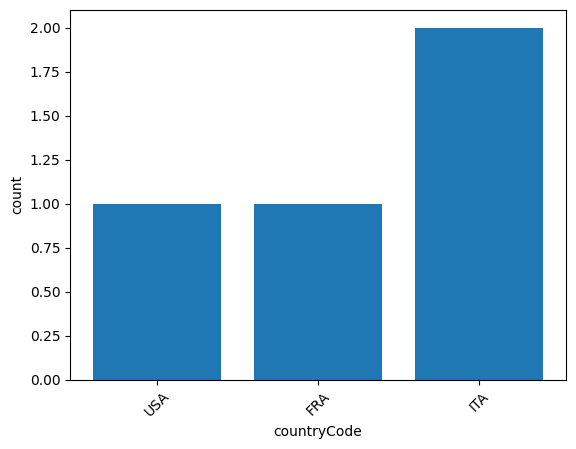

In [40]:
res_.bar();

The main strength of Relational DBs is the possibility of matching information from different tables though **Join** operations.

A join, either performed explicitely or implicitely is:

Just remember:
1. Computationally expensive. In case of large databases group by operations might require a long time to execute
2. Very easy to be done wrong, thus resulting in non-meaningful results

Be sure on which attributes (most often keys) you are performing a join operation.

- Join the `supplier_to_product` table with the `suppliers` table 

In [41]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[('supplierID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('supplierName', b'varchar(30)', 'NO', '', b'', ''),
 ('countryCode', b'char(3)', 'NO', '', b'ITA', ''),
 ('email', b'varchar(30)', 'NO', '', None, '')]

In [42]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('prodID', b'int', 'NO', 'PRI', None, ''),
 ('supID', b'int', 'NO', 'PRI', None, '')]

In [43]:
%%sql

SELECT *
FROM suppliers, supplier_to_product
WHERE suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[(1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 2, 1),
 (1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 3, 1)]

In [44]:
%%sql

SELECT *
FROM suppliers
INNER JOIN supplier_to_product ON suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[(1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 2, 1),
 (1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 3, 1)]

In [45]:
%%sql

SELECT *
FROM suppliers
LEFT JOIN supplier_to_product ON suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[(1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 2, 1),
 (1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 3, 1),
 (2, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com', None, None),
 (3, 'Wild Hops', 'ITA', 'myemail@wildhops.it', None, None),
 (4, 'Beer Paradise', 'ITA', 'beer@beerparadise.it', None, None)]

In [46]:
%%sql

SELECT *
FROM suppliers
RIGHT JOIN supplier_to_product ON suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[(1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 2, 1),
 (1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 3, 1)]

We can concatenate multiple join operations to extract higher level information out of the connections stored in the DB

- Add the corresponding product names the the previous join

In [47]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('productID', b'int', 'NO', 'PRI', None, 'auto_increment'),
 ('productName', b'varchar(30)', 'NO', '', b'', ''),
 ('unitPrice', b'float', 'NO', '', b'100000', ''),
 ('unitsInStock', b'int unsigned', 'NO', '', b'0', ''),
 ('isDiscontinued', b'tinyint(1)', 'NO', '', b'0', '')]

In [48]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[(1, 'Founders Porter', 4.9, 12, 0),
 (2, 'Punk IPA', 5.2, 45, 0),
 (3, 'HB Dunkel', 4.5, 250, 0),
 (5, 'Damm Complot', 3.7, 120, 0)]

In [49]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('prodID', b'int', 'NO', 'PRI', None, ''),
 ('supID', b'int', 'NO', 'PRI', None, '')]

In [50]:
%%sql

SELECT * FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[(2, 1), (3, 1)]

In [51]:
%%sql

SELECT *
FROM supplier_to_product
INNER JOIN suppliers ON suppliers.supplierID = supplier_to_product.supID
INNER JOIN products  ON products.productID   = supplier_to_product.prodID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[(2, 1, 1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 2, 'Punk IPA', 5.2, 45, 0),
 (3, 1, 1, 'A hop in the park', 'USA', 'anewemail@ahop.com', 3, 'HB Dunkel', 4.5, 250, 0)]

The conjunction of `SELECT`, `GROUP BY` and `JOIN` statements will allow us to extract non trivial information out of any Relational DB.

Add the following records to the `supplier_to_product` table and perform the following queries:
    
| supplier | products provided |
| --- | --- | 
| "Wild Hops" | "Founders Porter", "Punk IPA", "HB Dunkel", "Damm Complot" |    
| "Beer Paradise" | "Punk IPA", "Damm Complot" |    
| "Allez Hops! Cave à bièr" | "Founders Porter", "HB Dunkel" |    

1. show all suppliers of "Damm Complot"
2. retrieve the email address of all possible suppliers of "Punk IPA"
3. list the unit price of all products supplied by Italian firms, listed in descending order   

In [52]:
# import the connector
import mysql.connector

# declare a connection to the MySQL server 
# the hostname (or IP) of the server machine should be passed
db = mysql.connector.connect(
  user="root",
  password="root_pwd",
  host="db", # in this case 'db' is the equivalent of the IP address of the server 
             # or 'localhost' if running mysql locally
)

dbc=db.cursor()

In [53]:
dbc.execute("USE my_db")

In [54]:
sql_ = "INSERT INTO supplier_to_product (prodID, supID) VALUES (%s, %s)"
val_ = [
    # supplier Allez Hops
    (1, 2),
    (3, 2),

    # supplier Wild Hops
    (1, 3),
    (2, 3),
    (3, 3),
    (5, 3),

    # supplier Beer Paradise
    (2, 4),
    (5, 4),
]


dbc.executemany(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM supplier_to_product"); 
for _ in dbc:
     print(_)

(2, 1)
(3, 1)
(1, 2)
(3, 2)
(1, 3)
(2, 3)
(3, 3)
(5, 3)
(2, 4)
(5, 4)


#### 1 - show all suppliers of "Damm Complot"

In [55]:
%%sql

SELECT suppliers.supplierName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Damm Complot";

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('Wild Hops',), ('Beer Paradise',)]

#### 2 - retrieve the email address of all possible suppliers of "Punk IPA"

In [56]:
%%sql

SELECT suppliers.email 
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Punk IPA";

 * mysql+mysqlconnector://root:***@db
3 rows affected.


[('anewemail@ahop.com',), ('myemail@wildhops.it',), ('beer@beerparadise.it',)]

#### 3 - list the unit price of all products supplied by Italian firms, listed in descending order   

In [57]:
%%sql

SELECT DISTINCT products.unitPrice, products.productName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE suppliers.countryCode = "ITA"
ORDER BY unitPrice DESC;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[(5.2, 'Punk IPA'),
 (4.9, 'Founders Porter'),
 (4.5, 'HB Dunkel'),
 (3.7, 'Damm Complot')]

## 05 Queries on well-formed DBs

In MySQL we can load entire DBs from external files.

The files will contain the full DB structure (tables and constraints) and will populate all tables with all records 

To load a DB into the MySQL server from the interactive docker shell, we can simply do the following:

1. Create a new DB named `world`
2. Import the content of the file `/mapd-workspace/dbs/world.sql` into the newly created DB via
    
```bash
$ mysql -u root -p world < /mapd-workspace/dbs/world.sql
```

_NB_: The `opt/workspace` directory has been defined as a Docker Volume, and is a shared location with your computer...

Using the `world` DB, perform queries to answer the folliwing questions.

Additional references can be found here https://dev.mysql.com/doc/world-setup/en/


Use a single query to answer the questions

1. Which country has the largest population?
2. Get the total number of cities in Canada.
3. Select the country with the most cities.
4. List all the languages spoken in the Southeast Asia region.
5. Identify the 5 most spoken language by number of countries.
6. What is the total population of the cities in the Caribbean region?
7. What Countries have a City named "Kingston"?
8. Plot the population density by country, limiting to the 25 with least density.
9. Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with highest GNP.
10. Create a scatter plot of the life expentency vs the GNP of all countries that have Spanish as their Official language.


Suggestions:
- Start by inspecting the DB tables structure
- When in doubt, check the table content by selecting a few lines (use `LIMIT` to avoid returining all records)
- Before finalizing the query, you can always perform "intermediate" queries to check if complex operations (groupby and join mostly) are stated correctly

In [58]:
%%sql

USE world; 

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
3 rows affected.


[('city',), ('country',), ('countrylanguage',)]

#### 1 - Which country has the largest population?

In [66]:
%%sql 
SELECT Name AS Country, Population
FROM country
ORDER BY Population DESC
LIMIT 1;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[('China', 1277558000)]

In [85]:
%%sql 
SELECT Name AS Country, Code
FROM country
WHERE Code ="CAN";

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[('Canada', 'CAN')]

#### 2 - Get the total number of cities in Canada.

In [92]:
#soluzione del prof
%%sql 

SELECT COUNT(Name) AS CitiesInCanada
FROM city
WHERE CountryCode = "CAN";

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[(49,)]

In [97]:
%%sql 
SELECT country.Name AS Country, COUNT(city.CountryCode) AS nCity
FROM country
INNER JOIN city ON country.Code = city.CountryCode
WHERE Code = "CAN";

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[('Canada', 49)]

#### 3 - Select the country with the most cities.

In [ ]:
#soluzione del prof
%%sql 

SELECT CountryCode, COUNT(1) AS nCities
FROM city
GROUP BY CountryCode
ORDER BY nCities DESC
LIMIT 1;

#### 4 - List all the languages spoken in the 'Southeast Asia' region.

In [116]:
%%sql

SELECT Region, COUNT(1) AS nCountry
FROM country 
WHERE Region LIKE "%Asia"
GROUP BY Region;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


[('Southern and Central Asia', 14),
 ('Southeast Asia', 11),
 ('Eastern Asia', 8)]

In [115]:
%%sql 
SELECT DISTINCT Language
FROM countrylanguage
INNER JOIN country ON countrylanguage.CountryCode = country.Code
WHERE country.Region = 'Southeast Asia'
ORDER BY countrylanguage.Language ASC;

 * mysql+mysqlconnector://root:***@db
47 rows affected.


[('Bali',),
 ('Banja',),
 ('Batakki',),
 ('Bicol',),
 ('Bugi',),
 ('Burmese',),
 ('Cebuano',),
 ('Chin',),
 ('Chinese',),
 ('Dusun',),
 ('English',),
 ('Hiligaynon',),
 ('Iban',),
 ('Ilocano',),
 ('Javanese',),
 ('Kachin',),
 ('Karen',),
 ('Kayah',),
 ('Khmer',),
 ('Kuy',),
 ('Lao',),
 ('Lao-Soung',),
 ('Madura',),
 ('Maguindanao',),
 ('Malay',),
 ('Malay-English',),
 ('Man',),
 ('Maranao',),
 ('Miao',),
 ('Minangkabau',),
 ('Mon',),
 ('Mon-khmer',),
 ('Muong',),
 ('Nung',),
 ('Pampango',),
 ('Pangasinan',),
 ('Pilipino',),
 ('Portuguese',),
 ('Rakhine',),
 ('Shan',),
 ('Sunda',),
 ('Tamil',),
 ('Thai',),
 ('Tho',),
 ('Tšam',),
 ('Vietnamese',),
 ('Waray-waray',)]

#### 5 - Identify the 5 most spoken language by number of countries.

In [120]:
%%sql
SELECT countrylanguage.Language AS Language, COUNT(1) AS nCountry
FROM countrylanguage
GROUP BY countrylanguage.Language
ORDER BY nCountry DESC
LIMIT 5;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('English', 60),
 ('Arabic', 33),
 ('Spanish', 28),
 ('French', 25),
 ('German', 19)]

#### 6 - What is the total population of the cities in the Caribbean region?

In [136]:
%%sql

SELECT SUM(city.Population)
FROM city
LEFT JOIN country ON city.countryCode = country.Code
WHERE country.Region = 'Caribbean';

#soluzione prof

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[(Decimal('11067550'),)]

In [133]:
%%sql
SELECT Region, SUM(city.Population) AS TotalPopulationCity
FROM country
INNER JOIN city ON country.Code = city.CountryCode
WHERE Region ="Caribbean"
GROUP BY Region;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[('Caribbean', Decimal('11067550'))]

#### 7 - What Countries have a City named "Kingston"?

In [138]:
%%sql

SELECT country.Name, country.Region
FROM city
INNER JOIN country on city.CountryCode=country.Code
WHERE city.Name ="Kingston";

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('Jamaica', 'Caribbean'), ('Norfolk Island', 'Australia and New Zealand')]

#### 8 - Plot the population density by country, limiting to the 25 with least density.

 * mysql+mysqlconnector://root:***@db
25 rows affected.
+----------------------------------------------+---------+
|                     Name                     | density |
+----------------------------------------------+---------+
|     United States Minor Outlying Islands     |  0.0000 |
|        British Indian Ocean Territory        |  0.0000 |
|      Heard Island and McDonald Islands       |  0.0000 |
| South Georgia and the South Sandwich Islands |  0.0000 |
|                Bouvet Island                 |  0.0000 |
|         French Southern territories          |  0.0000 |
|                  Antarctica                  |  0.0000 |
|                  Greenland                   |  0.0259 |
|            Svalbard and Jan Mayen            |  0.0513 |
|               Falkland Islands               |  0.1643 |
|                   Pitcairn                   |  1.0204 |
|                Western Sahara                |  1.1015 |
|                   Mongolia                   |  1.6993 |


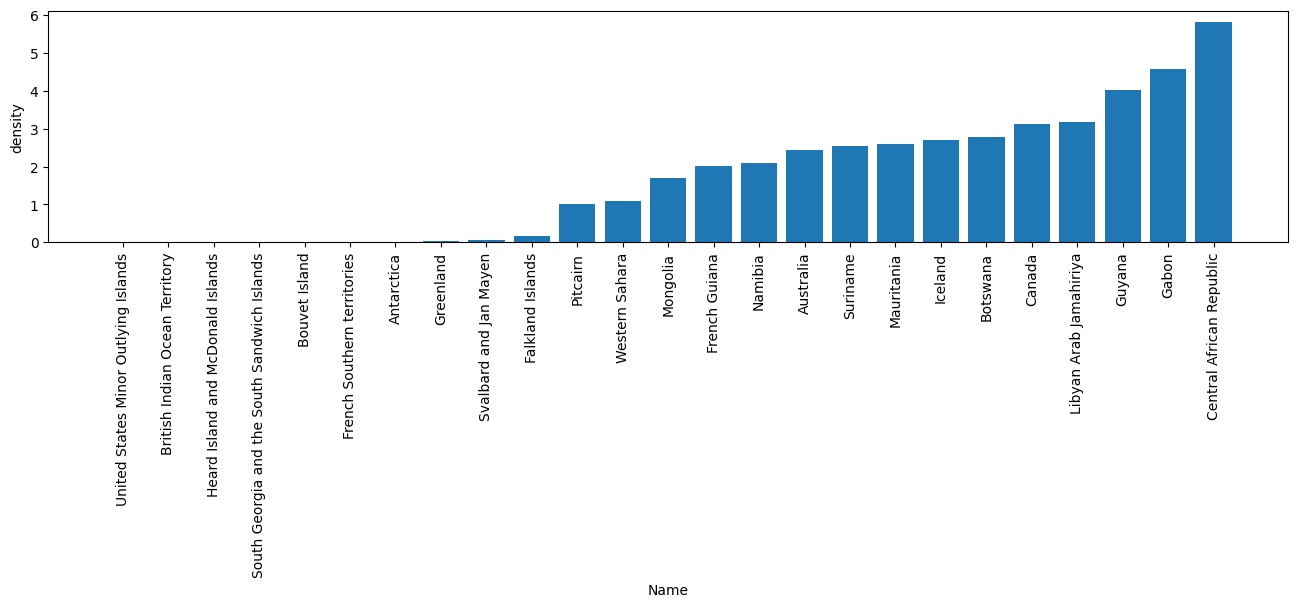

In [146]:
res_ = %sql SELECT  Name, Population/SurfaceArea AS density FROM  country  ORDER BY density ASC  LIMIT 25;

print(res_)

plt.figure(figsize=(16,3))
res_.bar();
plt.xticks(rotation='vertical');

In [147]:
%%sql
SELECT *
FROM country
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


[('ABW', 'Aruba', 'North America', 'Caribbean', Decimal('193.00'), None, 103000, Decimal('78.4'), Decimal('828.00'), Decimal('793.00'), 'Aruba', 'Nonmetropolitan Territory of The Netherlands', 'Beatrix', 129, 'AW'),
 ('AFG', 'Afghanistan', 'Asia', 'Southern and Central Asia', Decimal('652090.00'), 1919, 22720000, Decimal('45.9'), Decimal('5976.00'), None, 'Afganistan/Afqanestan', 'Islamic Emirate', 'Mohammad Omar', 1, 'AF'),
 ('AGO', 'Angola', 'Africa', 'Central Africa', Decimal('1246700.00'), 1975, 12878000, Decimal('38.3'), Decimal('6648.00'), Decimal('7984.00'), 'Angola', 'Republic', 'José Eduardo dos Santos', 56, 'AO'),
 ('AIA', 'Anguilla', 'North America', 'Caribbean', Decimal('96.00'), None, 8000, Decimal('76.1'), Decimal('63.20'), None, 'Anguilla', 'Dependent Territory of the UK', 'Elisabeth II', 62, 'AI'),
 ('ALB', 'Albania', 'Europe', 'Southern Europe', Decimal('28748.00'), 1912, 3401200, Decimal('71.6'), Decimal('3205.00'), Decimal('2500.00'), 'Shqipëria', 'Republic', 'Rexhep Mejdani', 34, 'AL'),
 ('AND', 'Andorra', 'Europe', 'Southern Europe', Decimal('468.00'), 1278, 78000, Decimal('83.5'), Decimal('1630.00'), None, 'Andorra', 'Parliamentary Coprincipality', '', 55, 'AD'),
 ('ANT', 'Netherlands Antilles', 'North America', 'Caribbean', Decimal('800.00'), None, 217000, Decimal('74.7'), Decimal('1941.00'), None, 'Nederlandse Antillen', 'Nonmetropolitan Territory of The Netherlands', 'Beatrix', 33, 'AN'),
 ('ARE', 'United Arab Emirates', 'Asia', 'Middle East', Decimal('83600.00'), 1971, 2441000, Decimal('74.1'), Decimal('37966.00'), Decimal('36846.00'), 'Al-Imarat al-´Arabiya al-Muttahida', 'Emirate Federation', 'Zayid bin Sultan al-Nahayan', 65, 'AE'),
 ('ARG', 'Argentina', 'South America', 'South America', Decimal('2780400.00'), 1816, 37032000, Decimal('75.1'), Decimal('340238.00'), Decimal('323310.00'), 'Argentina', 'Federal Republic', 'Fernando de la Rúa', 69, 'AR'),
 ('ARM', 'Armenia', 'Asia', 'Middle East', Decimal('29800.00'), 1991, 3520000, Decimal('66.4'), Decimal('1813.00'), Decimal('1627.00'), 'Hajastan', 'Republic', 'Robert Kotšarjan', 126, 'AM')]

#### 9 - Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with highest GNP.

 * mysql+mysqlconnector://root:***@db
10 rows affected.
+-------------+------------+
|     Name    |    GNP     |
+-------------+------------+
|    Italy    | 1161755.00 |
|    Canada   | 598862.00  |
|  Australia  | 351182.00  |
|     Iran    | 195746.00  |
|    Norway   | 145895.00  |
| New Zealand |  54669.00  |
|   Romania   |  38158.00  |
|     Cuba    |  17843.00  |
|  Luxembourg |  16321.00  |
|   Bulgaria  |  12178.00  |
+-------------+------------+


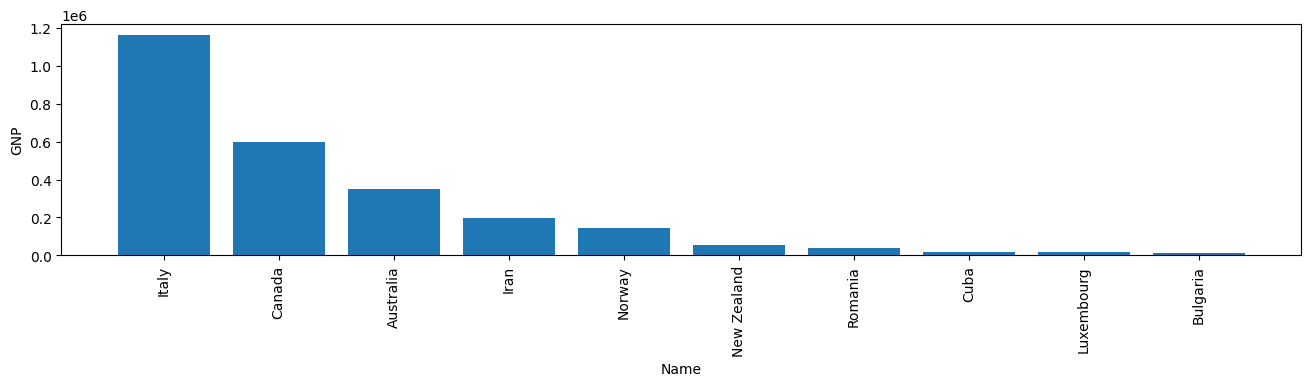

In [150]:
res_ = %sql SELECT  Name, GNP   FROM  country  WHERE  (IndepYear > 1850 AND IndepYear < 1910)  ORDER BY GNP DESC LIMIT 10;

print(res_)

plt.figure(figsize=(16,3))
res_.bar();
plt.xticks(rotation='vertical');

#### 10 - Create a scatter plot of the life expentency vs the GNP of all countries that have Spanish as their Official language.

 * mysql+mysqlconnector://root:***@db
20 rows affected.
+----------------+-----------+--------------------+
| LifeExpectancy |    GNP    |        Name        |
+----------------+-----------+--------------------+
|      75.1      | 340238.00 |     Argentina      |
|      63.7      |  8571.00  |      Bolivia       |
|      75.7      |  72949.00 |       Chile        |
|      70.3      | 102896.00 |      Colombia      |
|      75.8      |  10226.00 |     Costa Rica     |
|      76.2      |  17843.00 |        Cuba        |
|      73.2      |  15846.00 | Dominican Republic |
|      71.1      |  19770.00 |      Ecuador       |
|      78.8      | 553233.00 |       Spain        |
|      66.2      |  19008.00 |     Guatemala      |
|      69.9      |  5333.00  |      Honduras      |
|      71.5      | 414972.00 |       Mexico       |
|      68.7      |  1988.00  |     Nicaragua      |
|      75.5      |  9131.00  |       Panama       |
|      70.0      |  64140.00 |        Peru        |
|      7

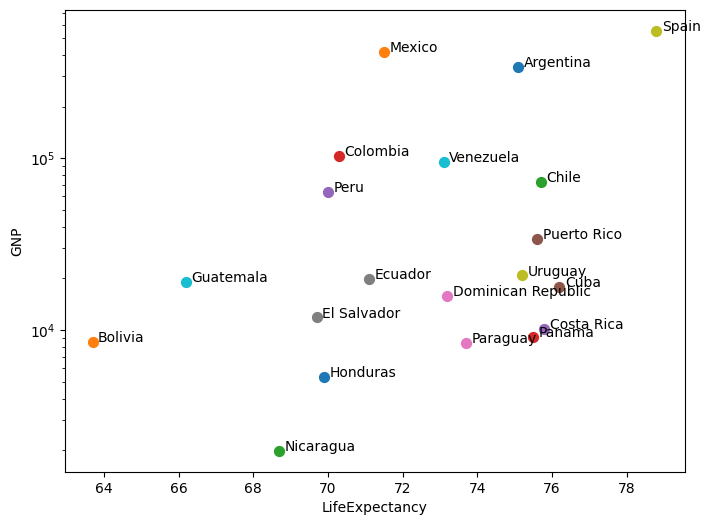

In [152]:
res_ = %sql SELECT  LifeExpectancy, GNP, country.Name \
            FROM  country\
            RIGHT JOIN  countrylanguage ON  country.Code = countrylanguage.CountryCode \
            WHERE countrylanguage.Language = "Spanish"\
            AND IsOfficial = 1;

print(res_)

plt.figure(figsize=(8,6))
for _ in res_:
    plt.scatter(_[0],_[1],s=50);
    plt.annotate(_[2], (float(_[0])*1.002,float(_[1])*1.002));
plt.ylabel('GNP')
plt.xlabel('LifeExpectancy')
plt.yscale('log')

## 06 More on queries 

Let' import a well-structured DB, with several tables and relationships, to be used as a sandbox for further exercises on queries.

The `.sql` file can be found at: `/mapd-workspace/dbs/IMDb_pruned.sql`.

The DB is freely available and is taken from the IMDb (Internet Movie Database) website (https://www.imdb.com/interfaces/).

The entire database is composed of a dozen of tables, hosing all people involved in Movies, Shorts, TV Show Epidoses and more since the 1890s. 

To simplify the execution of queries, we will work with a slimmed-down version of the entire DB, with still plenty of records for us to extract interesting information.

1. Create a new DB named `IMDb`
2. Import the content of the file `/mapd-workspace/dbs/IMDb_pruned.sql` into the newly created DB
(this might take a minute or two...)

### Check which tables are available

In [8]:
%%sql

USE IMDb;
SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
7 rows affected.


[('Directors',),
 ('Episode_belongs_to',),
 ('Had_role',),
 ('Names_',),
 ('Title_genres',),
 ('Title_ratings',),
 ('Titles',)]

### Describe the content of table Names_

In [9]:
%%sql

DESCRIBE Names_;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[('name_id', b'varchar(255)', 'NO', '', None, ''),
 ('name_', b'varchar(255)', 'NO', '', None, ''),
 ('birth_year', b'smallint', 'YES', '', None, ''),
 ('death_year', b'smallint', 'YES', '', None, '')]

### People by birth year

A) Start by limiting the query to 1000 entries

1. Draw an histogram of the year of birth
2. Draw a second histogram with the year of birth of the 1000 youngest people in the list

In [55]:
import mysql.connector
import itertools
import matplotlib.pyplot as plt

In [56]:
#A.1
db = mysql.connector.connect(
  user="root",
  password="root_pwd",
  host="db"
)

dbc = db.cursor()

dbc.execute("USE IMDb")

dbc.execute("SELECT birth_year FROM Names_ LIMIT 1000")
birth_year = dbc.fetchall() 

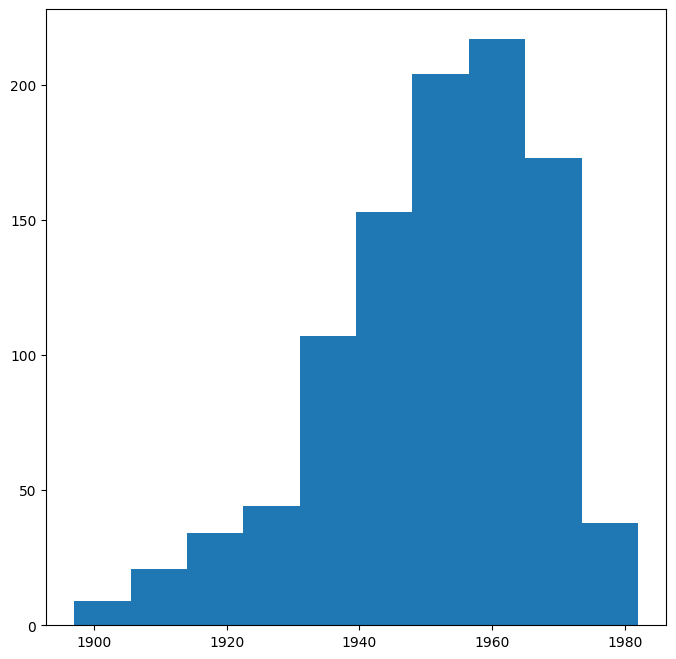

In [57]:
fig,ax=plt.subplots(1,1, figsize=(8,8))
ax.hist([x[0] for x in birth_year])
plt.show()

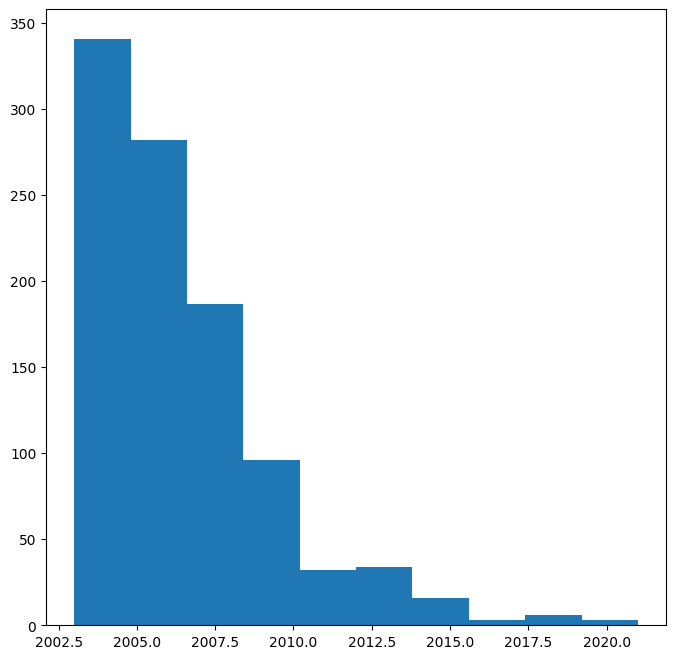

In [58]:
# A.2
dbc.execute("SELECT birth_year FROM Names_ ORDER BY birth_year DESC LIMIT 1000")
birth_year_young = dbc.fetchall() 

fig,ax=plt.subplots(1,1, figsize=(8,8))
ax.hist([x[0] for x in birth_year_young])
plt.show()

B) Extend the query to all records in the table

1. Check for outliers (inspect min and max)
2. If any outlier is found, limit the query to a reasonable range (at least people born after 1850)
3. Draw a new histogram with the year of birth
4. Compute the mean and std of year of birth

In [59]:
%%sql
#B.1
USE IMDb;

SELECT MIN(birth_year) AS Min ,MAX(birth_year) AS Max 
FROM Names_;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
1 rows affected.


[(13, 2021)]

In [60]:
%%sql
#B.2
SELECT birth_year,name_
FROM Names_ 
WHERE (birth_year < 1850);

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[(13, 'Karen Abercrombie'), (1088, 'Sophie Oliver')]

In [61]:
# Karen Abercrombie - 1964
#Sophie Oliver - 1988

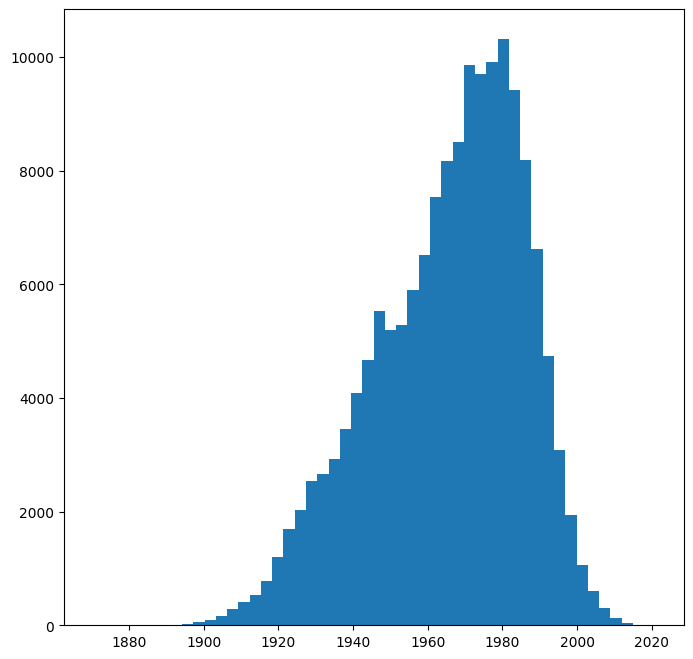

In [62]:
# B.3
dbc.execute("SELECT birth_year FROM Names_ WHERE birth_year > 1850")
birth_year_all = dbc.fetchall() 

fig,ax=plt.subplots(1,1, figsize=(8,8))
ax.hist([x[0] for x in birth_year_all],bins=50)
plt.show()

In [67]:
# B.4
dbc.execute("SELECT AVG(birth_year) AS mean, STD(birth_year) AS std FROM Names_ WHERE (birth_year > 1850)")
birth_stats = dbc.fetchall()

In [68]:
birth_stats

[(Decimal('1965.4513'), 19.99205313179966)]

### Movie stats

1. Plot how many titles can be found in the DB per year, over the past 25 years
2. List the names of all actors who have had the role of Spider-Man and the corresponding Title
3. List and count the 10 people who appeared the most in movies by "Wes Anderson"

In [76]:
%%sql

SELECT start_year, COUNT(1)\
FROM Titles\
WHERE start_year < 2023\
GROUP BY start_year\
ORDER BY start_year DESC\
LIMIT 25;

 * mysql+mysqlconnector://root:***@db
25 rows affected.


[(2022, 6211),
 (2021, 51422),
 (2020, 56755),
 (2019, 61580),
 (2018, 66211),
 (2017, 65984),
 (2016, 61554),
 (2015, 55864),
 (2014, 50654),
 (2013, 46740),
 (2012, 43170),
 (2011, 39155),
 (2010, 35706),
 (2009, 34450),
 (2008, 30564),
 (2007, 27860),
 (2006, 24898),
 (2005, 22746),
 (2004, 19711),
 (2003, 18189),
 (2002, 16937),
 (2001, 16598),
 (2000, 15677),
 (1999, 16643),
 (1998, 15749)]

#### 1 - Plot how many titles can be found in the DB per year, over the past 25 years

In [78]:
dbc.execute("SELECT start_year, COUNT(1) FROM Titles WHERE start_year < 2023 GROUP BY start_year ORDER BY start_year DESC LIMIT 25")
film_year=dbc.fetchall()

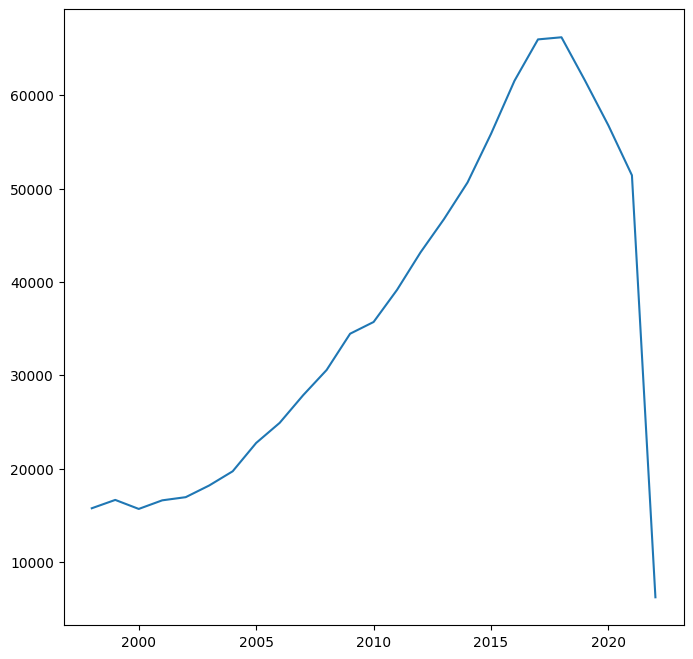

In [80]:
fig,ax=plt.subplots(1,1,figsize=(8,8))

ax.plot([x[0] for x in film_year], [x[1] for x in film_year])

plt.show()

#### 2 - List the names of all actors who have had the role of Spider-Man and the corresponding Title 

In [90]:
%%sql
SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
7 rows affected.


[('Directors',),
 ('Episode_belongs_to',),
 ('Had_role',),
 ('Names_',),
 ('Title_genres',),
 ('Title_ratings',),
 ('Titles',)]

In [89]:
%%sql

DESCRIBE Had_role;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


[('title_id', b'varchar(255)', 'NO', '', None, ''),
 ('name_id', b'varchar(255)', 'NO', '', None, ''),
 ('role_', b'text', 'NO', '', None, '')]

In [83]:
%%sql

DESCRIBE Names_;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[('name_id', b'varchar(255)', 'NO', '', None, ''),
 ('name_', b'varchar(255)', 'NO', '', None, ''),
 ('birth_year', b'smallint', 'YES', '', None, ''),
 ('death_year', b'smallint', 'YES', '', None, '')]

In [99]:
%%sql
DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('title_id', b'varchar(255)', 'NO', '', None, ''),
 ('title_type', b'varchar(50)', 'YES', '', None, ''),
 ('primary_title', b'text', 'YES', '', None, ''),
 ('start_year', b'int', 'YES', '', None, ''),
 ('runtime_minutes', b'int', 'YES', '', None, '')]

In [104]:
%%sql
SELECT DISTINCT Names_.name_ AS Name, Titles.primary_title AS Title
FROM Had_role
INNER JOIN Names_ ON Names_.name_id = Had_role.name_id
INNER JOIN Titles ON Titles.title_id = Had_role.title_id
WHERE role_ LIKE "Spider-Man";

 * mysql+mysqlconnector://root:***@db
309 rows affected.


[('Christopher Daniel Barnes', b'Spider-Man: The Animated Series'),
 ('Tobey Maguire', b'Spider-Man'),
 ('Neil Patrick Harris', b'Spider-Man'),
 ('Tobey Maguire', b'Spider-Man 2'),
 ('Tobey Maguire', b'Spider-Man 3'),
 ('Christopher Daniel Barnes', b'Day of the Chameleon'),
 ('Christopher Daniel Barnes', b'Doctor Octopus: Armed and Dangerous'),
 ('Christopher Daniel Barnes', b'Kraven the Hunter'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 10: The Immortal Vampire'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 11: Tablet of Time'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 12: Ravages of Time'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 13: Shriek of the Vulture'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 14: The Final Nightmare'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 1: The Insidious Six'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 2: Battle of the Insidious Six'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 3: Hydro-Man'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 4: The Mutant Agenda'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 5: Mutants Revenge'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 6: Morbius'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 7: Enter the Punisher'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 8: Duel of the Hunters'),
 ('Christopher Daniel Barnes', b'Neogenic Nightmare Chapter 9: Blade the Vampire Hunter'),
 ('Christopher Daniel Barnes', b'Night of the Lizard'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 10: Lizard King'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 11: The Prowler'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 1: Guilty'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 2: The Cat'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 3: The Black Cat'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 4: Return of Kraven'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 5: Partners'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 6: The Awakening'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 7: The Vampire Queen'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 8: The Return of the Green Goblin'),
 ('Christopher Daniel Barnes', b'Partners in Danger Chapter 9: The Haunting of Mary Jane'),
 ('Christopher Daniel Barnes', b'Secret Wars, Chapter 1: Arrival'),
 ('Christopher Daniel Barnes', b'Secret Wars, Chapter 2: The Gauntlet of the Red Skull'),
 ('Christopher Daniel Barnes', b'Secret Wars, Chapter 3: Doom'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 10: Venom Returns'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 11: Carnage'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 12: The Spot'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 13: Goblin War!'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 14: The Turning Point'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 1: Doctor Strange'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 2: Make a Wish'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 3: Attack of the Octobot'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 4: Enter the Green Goblin'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 5: The Rocket Racer'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 6: Framed'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 7: The Man Without Fear'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 8: The Ultimate Slayer'),
 ('Christopher Daniel Barnes', b'Sins of the Fathers Chapter 9: Tombstone'),
 ('Christopher Daniel Barnes', b'Six Forgotten Warriors Chapter 1'),
 ('Christopher Dani

#### 3 - List and count the 10 people who appeared the most in movies by "Wes Anderson"

In [105]:
%%sql

DESCRIBE Directors;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('title_id', b'varchar(255)', 'NO', '', None, ''),
 ('name_id', b'varchar(255)', 'NO', '', None, '')]

In [9]:
%%sql

SELECT Directors.title_id
FROM Directors
INNER JOIN Names_ ON Directors.name_id = Names_.name_id
WHERE Names_.name_ = "Wes Anderson";

 * mysql+mysqlconnector://root:***@db
10 rows affected.


[('tt0115734',),
 ('tt0128445',),
 ('tt0265666',),
 ('tt0362270',),
 ('tt0432283',),
 ('tt0838221',),
 ('tt1748122',),
 ('tt2278388',),
 ('tt5104604',),
 ('tt8847712',)]

In [14]:
%%sql 

SELECT Names_.name_ AS Name, COUNT(1) AS Appereance
FROM Had_role
INNER JOIN Names_ ON Had_role.name_id = Names_.name_id
WHERE (Had_role.title_id IN (
    SELECT Directors.title_id 
    FROM Directors
    INNER JOIN Names_ ON Directors.name_id = Names_.name_id
    WHERE (Names_.name_ LIKE "Wes Anderson" )
    ))
GROUP BY Names_.name_
ORDER BY Appereance DESC
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


[('Bill Murray', 4),
 ('Owen Wilson', 3),
 ('Jason Schwartzman', 3),
 ('Adrien Brody', 3),
 ('Anjelica Huston', 2),
 ('Ralph Fiennes', 1),
 ('Kara Hayward', 1),
 ('Gene Hackman', 1),
 ('Gwyneth Paltrow', 1),
 ('F. Murray Abraham', 1)]

### Is the IMDB only about movies? 

1. Check the number of different media types contained in the DB
2. Plot an histogram about the number of media types per group
3. Find the name and rating of the oldest videogame stored in the DB 

#### 1 - Check the number of different media types contained in the DB

In [5]:
%%sql

SELECT DISTINCT title_type AS MediaType, COUNT(1) AS NumberOf
FROM Titles
GROUP BY title_type;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('movie', 239353),
 ('tvEpisode', 708598),
 ('tvSeries', 59424),
 ('tvMiniSeries', 11963),
 ('videoGame', 257)]

#### 2 - Plot an histogram about the number of media types per group

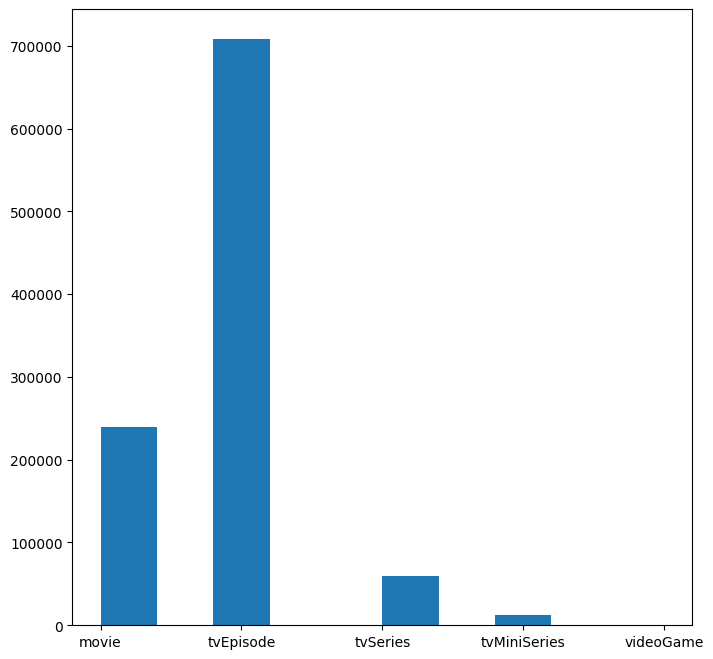

In [10]:
dbc.execute("SELECT title_type FROM Titles")
result = dbc.fetchall() 

fig,ax=plt.subplots(1,1, figsize=(8,8))
ax.hist([x[0] for x in result])
plt.show()

#### 3 - Find the name and rating of the oldest videogame stored in the DB 

In [12]:
%%sql
DESCRIBE Title_ratings;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


[('title_id', b'varchar(255)', 'NO', '', None, ''),
 ('average_rating', b'float', 'YES', '', None, ''),
 ('num_votes', b'int', 'YES', '', None, '')]

In [13]:
%%sql
DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('title_id', b'varchar(255)', 'NO', '', None, ''),
 ('title_type', b'varchar(50)', 'YES', '', None, ''),
 ('primary_title', b'text', 'YES', '', None, ''),
 ('start_year', b'int', 'YES', '', None, ''),
 ('runtime_minutes', b'int', 'YES', '', None, '')]

In [24]:
%%sql
SELECT MIN(Titles.start_year)
FROM Titles
WHERE (Titles.title_type = 'videoGame')
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[(1990,)]

In [25]:
%%sql
SELECT Titles.primary_title AS Title ,Title_ratings.average_rating AS Rating
FROM Titles
INNER JOIN Title_ratings ON Title_ratings.title_id = Titles.title_id
WHERE (Titles.title_type = "videoGame")
ORDER BY Titles.start_year ASC
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


[(b'Lord of the Rings', 6.9),
 (b'The Simpsons', 8.4),
 (b'Land of Illusion', 7.3),
 (b'Sim City Enhanced CD-ROM', 7.0),
 (b'Alien Carnage', 6.8),
 (b'Star Trek the Next Generation Interactive VHS Board Game', 8.2),
 (b'Crusader of Centy', 8.0),
 (b'Ride for Your Life', 5.9),
 (b'Mr. Payback: An Interactive Movie', 4.7),
 (b'Maximum Surge', 4.1)]

### Identify interesting outliers 

1. List the names of movies whose title begin with "The" have a runtime between 3 and 4 hours.
2. What actor had the most roles as 'Self'?
3. Identify what TV series had more than 1,000 episodes, and check the first- and last-episod year

#### 1 - List the names of movies whose title begin with "The" have a runtime between 3 and 4 hours.

In [32]:
%%sql
SELECT Titles.primary_title AS Title
FROM Titles
WHERE (Titles.primary_title LIKE "The%" 
       AND (Titles.runtime_minutes BETWEEN (3*60) AND (4*60)) 
       AND Titles.title_type = "movie");

 * mysql+mysqlconnector://root:***@db
116 rows affected.


[(b'The Beautiful Troublemaker',),
 (b'The Best Intentions',),
 (b'The Wonderful, Horrible Life of Leni Riefenstahl',),
 (b'The Decline of the Century: Testament L.Z.',),
 (b'The Beginning and the End',),
 (b'The Barber of Siberia',),
 (b'The Green Mile',),
 (b'The Year After Dayton',),
 (b'The Sleep Room',),
 (b'The Lord of the Rings: The Return of the King',),
 (b'The Big House',),
 (b'The Murder of JFK: A Revisionist History',),
 (b'The Girl Who Picks Flowers and the Girl Who Kills Insects',),
 (b'The Dialogues with Solzhenitsyn',),
 (b'The Black Sheep',),
 (b'The Charioteer',),
 (b'The Himmler Project',),
 (b'The King',),
 (b'The Legend of Suriyothai',),
 (b'The Gospel of John',),
 (b'The Ister',),
 (b'The Garden',),
 (b'The Last Pogo Jumps Again',),
 (b'The Lottery of the Sea',),
 (b'The Wolf of Wall Street',),
 (b'The Lehman Trilogy',),
 (b'The Royal Opera House: Faust',),
 (b'The Boro: Fight for Identity',),
 (b'The Cinema of Ozu According to Kiju Yoshida',),
 (b'The Secret Fighting Arts of America: Expedition Highlights',),
 (b'The Twilight Zone: A 60th Anniversary Celebration',),
 (b'The Most Important Film Ever Made: The Making of A One Crow World',),
 (b'The Grateful Dead Meet-Up 2018',),
 (b'The Year of the Discovery',),
 (b'The Uncertain Kingdom',),
 (b'The Entertainer',),
 (b'The Baby Doll Night',),
 (b'The History of Tanks',),
 (b'The English Organ',),
 (b'The Last Mission',),
 (b'The Outcast',),
 (b'The Irishman',),
 (b'The House of the Silent Bat',),
 (b'The Real Thing',),
 (b'The Unbroken',),
 (b"The Winter's Tale - Rehearsed Reading",),
 (b'The Sodomite Deception',),
 (b'The Challenge of Rudolf Steiner',),
 (b'The Power Was with Us: Idle No More',),
 (b'The Electric Paradise',),
 (b'The Autobiography of Nicolae Ceausescu',),
 (b'The Wind Blows Where It Will',),
 (b'The Hamburg Ballet John Neumeier - A Young Choreographers Evening 2021',),
 (b'The Last Job',),
 (b'The Jim Breuer Road Journals',),
 (b'The Truth About The Philadelphia Experiment: Invisibility, Time Travel and Mind Control - The Shocking Truth',),
 (b'The Money Masters',),
 (b'The King and the Commissioner',),
 (b'The Battleships',),
 (b"The Word Is Love: Jamaica's Michael Manley",),
 (b'The Fourth Reich',),
 (b'The Ultimate 2012 Collection: Explore the Mystery of the Mayan Prophecy',),
 (b'The Turning',),
 (b'The Last of the Unjust',),
 (b'The Adventure of Cohollyingwood Black Prince',),
 (b'The Furious Gods: Making Prometheus',),
 (b'The Story of Jonah and the Whale (Sort of...)',),
 (b'The Oscar Nominated Short Films 2013: Documentary',),
 (b'The Pogo Film Project',),
 (b"The Gershwin's 'Porgy and Bess'",),
 (b'The Great Rome 3D',),
 (b'The Clairvoyant Fortune',),
 (b'The Gospel of Matthew',),
 (b'The Art of Seeing',),
 (b'The Company We Keep',),
 (b'The Will: If Only There Were No Nuclear Power Plant',),
 (b'The Oscar Nominated Short Films 2014: Documentary',),
 (b'The Presidents: From Politics to Power',),
 (b'The Life & Times of Abdullah the Butcher',),
 (b'The Insignificance of Being Gwendolen',),
 (b'The Gospel of Luke',),
 (b'The Faithful',),
 (b'The Rake Creatures',),
 (b'The Master Class Part 2',),
 (b'The Crucible',),
 (b'The American Tapes: Tales of Immigration',),
 (b'The Future of Freedom: An Interview with NSA Whistleblower William Binney',),
 (b'The Extincts',),
 (b'The Next Generation Movie',),
 (b'The Townie',),
 (b'The Conciousnous Paradigm',),
 (b'The Age of Czeslaw Milosz',),
 (b'The Marvel Experience',),
 (b'The Great Everything & the Nothing',),
 (b'The Royal Opera House: La Traviata',),
 (b'The Way of Thorns',),
 (b'The Nightmare Series Encyclopedia',),
 (b'The Woman Who Left',),
 (b'The Chrysanthemum and the Guillotine',),
 (b'The Wild Pear Tree',),
 (b'The Corporation Nation Master',),
 (b'The World Is Ending Tomorrow',),
 (b'The Witch of Funtinel',),
 (b'The Royal Opera House: Il trovatore',),
 (b'The Republic',),
 (b'The Poet Professor',),
 (b'The Bastard Sword',),
 (b'The Wild Frontier',),
 (b'The Mystery of Godline

In [39]:
%%sql
DESCRIBE Names_;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[('name_id', b'varchar(255)', 'NO', '', None, ''),
 ('name_', b'varchar(255)', 'NO', '', None, ''),
 ('birth_year', b'smallint', 'YES', '', None, ''),
 ('death_year', b'smallint', 'YES', '', None, '')]

#### 2 - What actor had the most roles as 'Self'?

In [40]:
%%sql 

SELECT Names_.name_ AS Actor, COUNT(1) AS Times
FROM Names_
INNER JOIN Had_role ON Names_.name_id = Had_role.name_id
WHERE Had_role.role_ = "Self"
GROUP BY Names_.name_
ORDER BY Times DESC
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


[('Scott Morrison', 3197),
 ('Tony Abbott', 2763),
 ('Donald Trump', 2210),
 ('John Howard', 1162),
 ('Pauline Hanson', 1099),
 ('Peter Dutton', 1044),
 ('Barnaby Joyce', 998),
 ('Paul Bowman', 798),
 ('Arin Hanson', 792),
 ('Brad Jones', 751)]

#### 3 - Identify what TV series had more than 1,000 episodes, and check the first- and last-episod year

In [44]:
%%sql
SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
7 rows affected.


[('Directors',),
 ('Episode_belongs_to',),
 ('Had_role',),
 ('Names_',),
 ('Title_genres',),
 ('Title_ratings',),
 ('Titles',)]

In [46]:
%%sql 

SELECT DISTINCT title_type
FROM Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


[('movie',), ('tvEpisode',), ('tvSeries',), ('tvMiniSeries',), ('videoGame',)]

In [78]:
%%sql 

SELECT *
FROM Titles
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


[('tt0011216', 'movie', b'Spanish Fiesta', 2019, 67),
 ('tt0015724', 'movie', b'Dama de noche', 1993, 102),
 ('tt0035423', 'movie', b'Kate & Leopold', 2001, 118),
 ('tt0059325', 'movie', b"Born in '45", 1990, 100),
 ('tt0059900', 'movie', b'Wenn du gro\xc3\x9f bist, lieber Adam', 1990, 78),
 ('tt0062336', 'movie', b'The Tango of the Widower and Its Distorting Mirror', 2020, 70),
 ('tt0063351', 'movie', b'Summer in Narita', 2012, 108),
 ('tt0065188', 'movie', b'Vojtech, receny sirotek', 1990, 80),
 ('tt0067460', 'movie', b'My Kingdom for...', 1995, 85),
 ('tt0068494', 'movie', b'Domo Arigato', 1990, 91)]

In [79]:
%%sql

CREATE VIEW Tv1KEpisodes AS
SELECT Titles.primary_title, Titles.title_id,Titles.start_year, COUNT(1)
FROM Episode_belongs_to
INNER JOIN Titles ON Titles.title_id = Episode_belongs_to.parent_tv_show_title_id
WHERE Titles.title_type IN ("tvEpisode","tvSeries","tvMiniSeries")
GROUP BY Titles.primary_title,Titles.title_id,Titles.start_year
HAVING COUNT(1)>1000
ORDER BY COUNT(1) DESC;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [80]:
%%sql
SELECT *
FROM Tv1KEpisodes
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


[(b'Charlie Rose', 'tt0270116', 1991, 9884),
 (b'Gute Zeiten, schlechte Zeiten', 'tt0103434', 1992, 7455),
 (b'Judge Judy', 'tt0115227', 1996, 7282),
 (b'Unter uns', 'tt0108977', 1994, 6803),
 (b'Late Show with David Letterman', 'tt0106053', 1993, 6691),
 (b'Goede tijden, slechte tijden', 'tt0096597', 1990, 6550),
 (b'Young Hearts', 'tt0144724', 1995, 6247),
 (b'DAS!', 'tt0289801', 1991, 5433),
 (b"L'invit\xc3\xa9", 'tt4816922', 2000, 5273),
 (b'Volle Kanne', 'tt0498891', 1999, 5111)]

### It's all about the ratings 

1. Group all movies by decade and plot the rating distribution. Limit the query to the movies with at least 1000 ratings.
2. Plot the average rating of each episode of Games of Thrones. Group by season and compute the average and std for each season
3. Plot the total numer of movies per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre

#### 1 - Group all movies by decade and plot the rating distribution. Limit the query to the movies with at least 1000 ratings.

In [94]:
%%sql

SELECT Titles.primary_title, 10*FLOOR(Titles.start_year/10) AS Decade, Title_ratings.average_rating, Title_ratings.num_votes
FROM Title_ratings
INNER JOIN Titles ON Titles.title_id = Title_ratings.title_id
WHERE (Title_ratings.num_votes>1000 AND Titles.title_type = "movie" AND Titles.start_year IS NOT NULL)
ORDER BY Titles.start_year ASC;

 * mysql+mysqlconnector://root:***@db
26827 rows affected.


[(b'Abuk Sabuk 1 Film', 1990, 6.3, 1107),
 (b'Gremlins 2: The New Batch', 1990, 6.4, 100985),
 (b'A Nymphoid Barbarian in Dinosaur Hell', 1990, 2.7, 1678),
 (b'Come See the Paradise', 1990, 6.7, 2792),
 (b'Edward Scissorhands', 1990, 7.9, 472358),
 (b'Shadowzone', 1990, 5.1, 1096),
 (b'No: 20 Madras Mail', 1990, 7.7, 1187),
 (b'Narrow Margin', 1990, 6.6, 8956),
 (b'White Palace', 1990, 6.5, 8084),
 (b'The Prisoner', 1990, 5.8, 3529),
 (b'My Blue Heaven', 1990, 6.3, 20416),
 (b'RoboCop 2', 1990, 5.8, 85098),
 (b'American Ninja 4: The Annihilation', 1990, 4.0, 4921),
 (b"Child's Play 2", 1990, 5.9, 49928),
 (b'The Russia House', 1990, 6.1, 15887),
 (b'Maniac Nurses find Ecstasy', 1990, 2.8, 1185),
 (b'The Freshman', 1990, 6.5, 19873),
 (b'The Witches', 1990, 6.9, 48558),
 (b'City Life', 1990, 7.9, 4109),
 (b'Faces of Death IV', 1990, 3.4, 1217),
 (b'Swarg', 1990, 6.7, 1415),
 (b'Rosencrantz & Guildenstern Are Dead', 1990, 7.4, 21788),
 (b'Young Guns II', 1990, 6.5, 35204),
 (b'Def by Temptation', 1990, 4.9, 1578),
 (b"Macken - Roy's & Roger's Bilservice", 1990, 6.1, 1097),
 (b'Koko Flanel', 1990, 6.3, 2194),
 (b'Bullet in the Head', 1990, 7.6, 10570),
 (b'A Shock to the System', 1990, 6.7, 4891),
 (b'Solar Crisis', 1990, 4.0, 1904),
 (b'The Two Jakes', 1990, 6.2, 13760),
 (b'Frankenstein Unbound', 1990, 5.5, 3774),
 (b'Pacific Heights', 1990, 6.4, 19916),
 (b'Awakenings', 1990, 7.8, 136225),
 (b'Sgt. Kabukiman N.Y.P.D.', 1990, 5.8, 2939),
 (b'Coupe de Ville', 1990, 6.7, 2468),
 (b'Far Out Man', 1990, 5.0, 1113),
 (b'Home Alone', 1990, 7.6, 547692),
 (b'Auntie Danielle', 1990, 7.1, 3500),
 (b'Die Hard 2', 1990, 7.1, 354604),
 (b'The Invisible Maniac', 1990, 4.0, 2725),
 (b'Bird on a Wire', 1990, 6.0, 43697),
 (b'Brain Dead', 1990, 6.0, 4511),
 (b'Soultaker', 1990, 2.4, 3833),
 (b"S'en fout la mort", 1990, 6.7, 1059),
 (b'Back to the Future Part III', 1990, 7.4, 430815),
 (b'The Ages of Lulu', 1990, 5.6, 3789),
 (b'Fantozzi alla riscossa', 1990, 5.8, 1447),
 (b'Love at Large', 1990, 5.7, 1275),
 (b"Miller's Crossing", 1990, 7.7, 132827),
 (b'Predator 2', 1990, 6.3, 156925),
 (b'Trust', 1990, 7.4, 11146),
 (b'The Crawlers', 1990, 2.8, 1358),
 (b'First Rank', 1990, 5.3, 1146),
 (b'Hamlet', 1990, 6.7, 22233),
 (b'Henry & June', 1990, 6.3, 13091),
 (b'Slacker', 1990, 7.1, 21192),
 (b'Werner - Beinhart!', 1990, 6.7, 5708),
 (b'Halfaouine: Boy of the Terraces', 1990, 6.7, 1303),
 (b'Demonia', 1990, 4.6, 1506),
 (b'Alienator', 1990, 3.2, 1599),
 (b'Baby Blood', 1990, 6.0, 1838),
 (b'Catchfire', 1990, 5.3, 3916),
 (b'A Tale of Springtime', 1990, 7.2, 4429),
 (b'Dezha vyu', 1990, 7.6, 1356),
 (b'Flesh Gordon Meets the Cosmic Cheerleaders', 1990, 3.7, 1590),
 (b'I Bought a Vampire Motorcycle', 1990, 5.6, 1237),
 (b'In the Cold of the Night', 1990, 4.4, 1621),
 (b'The Local Stigmatic', 1990, 5.8, 1561),
 (b'Mathilukal', 1990, 8.4, 1245),
 (b'May Fools', 1990, 7.3, 3124),
 (b'Moon 44', 1990, 5.1, 5168),
 (b'Prom Night III: The Last Kiss', 1990, 4.6, 2194),
 (b'Spontaneous Combustion', 1990, 4.8, 2593),
 (b'The Death King', 1990, 6.5, 2502),
 (b'The Match Factory Girl', 1990, 7.6, 9723),
 (b'The Voice of the Moon', 1990, 6.3, 2908),
 (b'Three Men and a Little Lady', 1990, 5.5, 24352),
 (b'Boiling Point', 1990, 6.8, 6699),
 (b'The Adventures of Ford Fairlane', 1990, 6.4, 17944),
 (b'After Dark, My Sweet', 1990, 6.6, 3535),
 (b'Agneepath', 1990, 7.7, 8842),
 (b'Air America', 1990, 5.8, 28370),
 (b'Alice', 1990, 6.6, 14174),
 (b'Almost an Angel', 1990, 5.6, 4552),
 (b'The Ambulance', 1990, 5.9, 3512),
 (b'An Angel at My Table', 1990, 7.5, 7585),
 (b'Anjali', 1990, 8.2, 2951),
 (b'Another 48 Hrs.', 1990, 5.9, 40967),
 (b'Arachnophobia', 1990, 6.4, 68381),
 (b'Archangel', 1990, 6.5, 1440),
 (b'Avalon', 1990, 7.2, 6238),
 (b'BlackJack', 1990, 5.7, 1531),
 (b'Miami Blues', 1990, 6.4, 8549),
 (b'Across the Tracks', 1990, 5.8, 2395),
 (b'Death in Brunswick', 1990, 6.6, 1211),
 (b'Boynu B\xc3\xbck\xc3\xbck K\xc3\xbcheylan', 1990, 6.4, 1063),
 (b'House P

In [97]:
%%sql

SELECT 10*FLOOR(Titles.start_year/10) AS Decade, AVG(Title_ratings.average_rating) AS MeanRating
FROM Title_ratings
INNER JOIN Titles ON Titles.title_id = Title_ratings.title_id
WHERE (Title_ratings.num_votes>1000 AND Titles.title_type = "movie" AND Titles.start_year IS NOT NULL)
GROUP BY Decade
ORDER BY Decade ASC;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[(1990, 6.364565547778342),
 (2000, 6.246381951759197),
 (2010, 6.158357727336619),
 (2020, 6.268965520191386)]

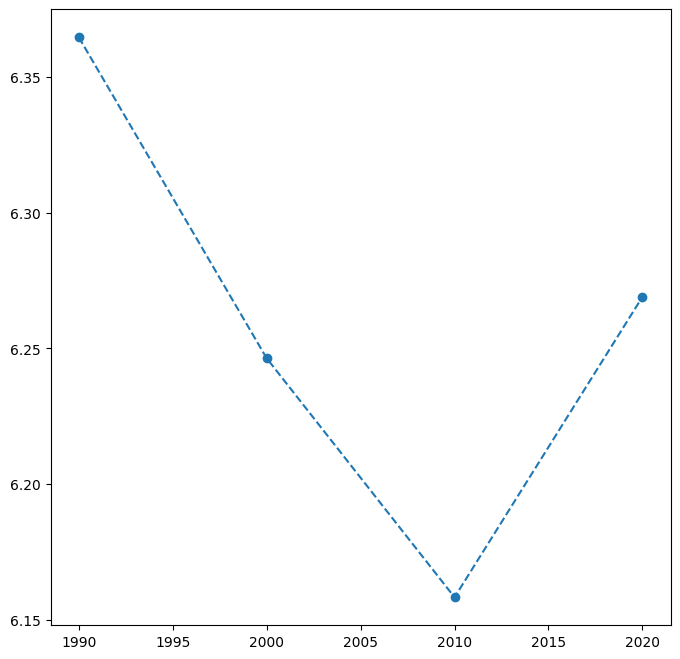

In [100]:
dbc.execute("SELECT 10*FLOOR(Titles.start_year/10) AS Decade, AVG(Title_ratings.average_rating) AS MeanRating FROM Title_ratings INNER JOIN Titles ON Titles.title_id = Title_ratings.title_id WHERE (Title_ratings.num_votes>1000 AND Titles.title_type = 'movie' AND Titles.start_year IS NOT NULL) GROUP BY Decade ORDER BY Decade ASC")

result = dbc.fetchall() 

fig,ax=plt.subplots(1,1, figsize=(8,8))
ax.scatter([x[0] for x in result],[x[1] for x in result])
ax.plot([x[0] for x in result],[x[1] for x in result],linestyle="dashed")
plt.show()

#### 2 - Plot the average rating of each episode of Games of Thrones. Group by season and compute the average and std for each season

In [110]:
%%sql
DESCRIBE Episode_belongs_to;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[('episode_title_id', b'varchar(255)', 'NO', '', None, ''),
 ('parent_tv_show_title_id', b'varchar(255)', 'NO', '', None, ''),
 ('season_number', b'int', 'YES', '', None, ''),
 ('episode_number', b'int', 'YES', '', None, '')]

In [ ]:
%%sql
SELECT Episode_belongs_to.season_number AS Season,Episode_belongs_to.episode_number AS Episode, Title_ratings.average_rating AS Rating
FROM Episode_belongs_to
INNER JOIN Title_ratings ON Episode_belongs_to.episode_title_id = Title_ratings.title_id
LIMIT 10;

 * mysql+mysqlconnector://root:***@db


In [10]:
%%sql

SELECT T.primary_title, E.season_number, E.episode_number, R.average_rating
FROM Episode_belongs_to E
INNER JOIN Titles T ON T.title_id = E.episode_title_id
INNER JOIN Title_ratings R ON R.title_id = E.episode_title_id
WHERE parent_tv_show_title_id = (
    SELECT title_id
    FROM Titles
    WHERE primary_title = 'Game of Thrones'
    AND title_type = 'tvSeries'
)
ORDER BY E.season_number;

 * mysql+mysqlconnector://root:***@db
73 rows affected.


[(b'Winter Is Coming', 1, 1, 9.1),
 (b'The Kingsroad', 1, 2, 8.8),
 (b'Lord Snow', 1, 3, 8.7),
 (b'Cripples, Bastards, and Broken Things', 1, 4, 8.8),
 (b'The Wolf and the Lion', 1, 5, 9.1),
 (b'A Golden Crown', 1, 6, 9.2),
 (b'You Win or You Die', 1, 7, 9.2),
 (b'The Pointy End', 1, 8, 9.0),
 (b'Baelor', 1, 9, 9.6),
 (b'Fire and Blood', 1, 10, 9.5),
 (b'The North Remembers', 2, 1, 8.8),
 (b'The Night Lands', 2, 2, 8.5),
 (b'What Is Dead May Never Die', 2, 3, 8.8),
 (b'Garden of Bones', 2, 4, 8.8),
 (b'The Ghost of Harrenhal', 2, 5, 8.8),
 (b'The Old Gods and the New', 2, 6, 9.1),
 (b'A Man Without Honor', 2, 7, 8.9),
 (b'The Prince of Winterfell', 2, 8, 8.8),
 (b'Blackwater', 2, 9, 9.7),
 (b'Valar Morghulis', 2, 10, 9.4),
 (b'Valar Dohaeris', 3, 1, 8.8),
 (b'Dark Wings, Dark Words', 3, 2, 8.6),
 (b'Walk of Punishment', 3, 3, 8.9),
 (b'And Now His Watch Is Ended', 3, 4, 9.6),
 (b'Kissed by Fire', 3, 5, 9.0),
 (b'The Climb', 3, 6, 8.8),
 (b'The Bear and the Maiden Fair', 3, 7, 8.7),
 (b'Second Sons', 3, 8, 9.0),
 (b'The Rains of Castamere', 3, 9, 9.9),
 (b'Mhysa', 3, 10, 9.2),
 (b'Two Swords', 4, 1, 9.1),
 (b'The Lion and the Rose', 4, 2, 9.7),
 (b'Breaker of Chains', 4, 3, 8.9),
 (b'Oathkeeper', 4, 4, 8.8),
 (b'First of His Name', 4, 5, 8.8),
 (b'The Laws of Gods and Men', 4, 6, 9.7),
 (b'Mockingbird', 4, 7, 9.1),
 (b'The Mountain and the Viper', 4, 8, 9.7),
 (b'The Watchers on the Wall', 4, 9, 9.6),
 (b'The Children', 4, 10, 9.7),
 (b'The Wars to Come', 5, 1, 8.5),
 (b'The House of Black and White', 5, 2, 8.5),
 (b'High Sparrow', 5, 3, 8.5),
 (b'Sons of the Harpy', 5, 4, 8.7),
 (b'Kill the Boy', 5, 5, 8.6),
 (b'Unbowed, Unbent, Unbroken', 5, 6, 8.0),
 (b'The Gift', 5, 7, 9.0),
 (b'Hardhome', 5, 8, 9.9),
 (b'The Dance of Dragons', 5, 9, 9.5),
 (b"Mother's Mercy", 5, 10, 9.1),
 (b'The Red Woman', 6, 1, 8.5),
 (b'Home', 6, 2, 9.4),
 (b'Oathbreaker', 6, 3, 8.7),
 (b'Book of the Stranger', 6, 4, 9.1),
 (b'The Door', 6, 5, 9.7),
 (b'Blood of My Blood', 6, 6, 8.4),
 (b'The Broken Man', 6, 7, 8.6),
 (b'No One', 6, 8, 8.4),
 (b'Battle of the Bastards', 6, 9, 9.9),
 (b'The Winds of Winter', 6, 10, 9.9),
 (b'Dragonstone', 7, 1, 8.6),
 (b'Stormborn', 7, 2, 8.9),
 (b"The Queen's Justice", 7, 3, 9.2),
 (b'The Spoils of War', 7, 4, 9.8),
 (b'Eastwatch', 7, 5, 8.8),
 (b'Beyond the Wall', 7, 6, 9.0),
 (b'The Dragon and the Wolf', 7, 7, 9.4),
 (b'Winterfell', 8, 1, 7.5),
 (b'A Knight of the Seven Kingdoms', 8, 2, 7.8),
 (b'The Long Night', 8, 3, 7.4),
 (b'The Last of the Starks', 8, 4, 5.4),
 (b'The Bells', 8, 5, 5.9),
 (b'The Iron Throne', 8, 6, 4.0)]

In [19]:
%%sql

SELECT E.season_number, AVG(R.average_rating), STD(R.average_rating)
FROM Episode_belongs_to E
INNER JOIN Titles T ON T.title_id = E.episode_title_id
INNER JOIN Title_ratings R ON R.title_id = E.episode_title_id
WHERE parent_tv_show_title_id = (
    SELECT title_id
    FROM Titles
    WHERE primary_title = 'Game of Thrones'
    AND title_type = 'tvSeries'
)
GROUP BY E.season_number
ORDER BY E.season_number;

 * mysql+mysqlconnector://root:***@db
8 rows affected.


[(1, 9.100000095367431, 0.279284841851893),
 (2, 8.960000038146973, 0.3322648385598139),
 (3, 9.05, 0.3905124105321288),
 (4, 9.310000038146972, 0.3832752574106418),
 (5, 8.830000019073486, 0.5273518051323894),
 (6, 9.05999984741211, 0.588557477116479),
 (7, 9.099999972752162, 0.37416567313687327),
 (8, 6.333333412806193, 1.3634107864471021)]

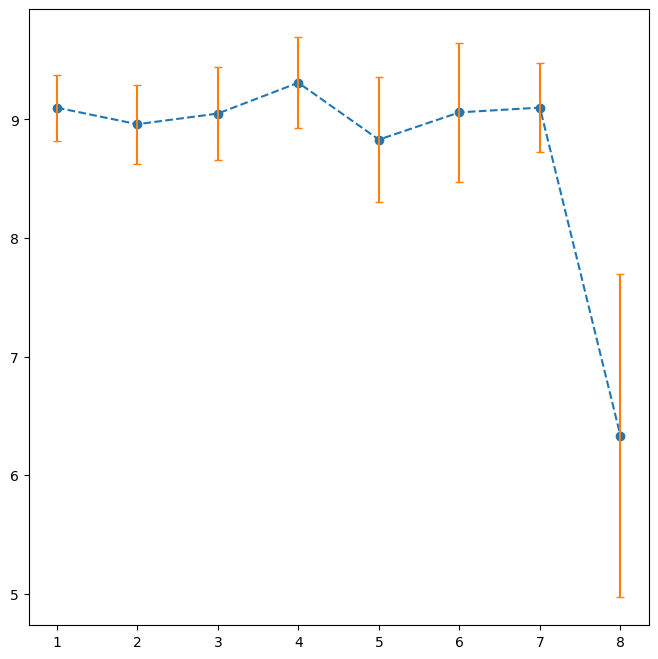

In [25]:
sql_="SELECT E.season_number, AVG(R.average_rating), STD(R.average_rating) \
FROM Episode_belongs_to E \
INNER JOIN Titles T ON T.title_id = E.episode_title_id \
INNER JOIN Title_ratings R ON R.title_id = E.episode_title_id \
WHERE parent_tv_show_title_id = ( \
    SELECT title_id \
    FROM Titles \
    WHERE primary_title = 'Game of Thrones' \
    AND title_type = 'tvSeries' \
) \
GROUP BY E.season_number \
ORDER BY E.season_number"

dbc.execute(sql_)
result=dbc.fetchall()

fig,ax=plt.subplots(1,1, figsize=(8,8))
ax.scatter([x[0] for x in result],[x[1] for x in result])
ax.plot([x[0] for x in result],[x[1] for x in result],linestyle="dashed")
ax.errorbar([x[0] for x in result],[x[1] for x in result],
            yerr=[x[2] for x in result], xerr=None,
            linestyle="none",capsize=3)
plt.show()

#### 3 - Plot the total numer of movies per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre

In [26]:
%%sql
SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
7 rows affected.


[('Directors',),
 ('Episode_belongs_to',),
 ('Had_role',),
 ('Names_',),
 ('Title_genres',),
 ('Title_ratings',),
 ('Titles',)]

In [28]:
%%sql
DESCRIBE Title_genres;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[('title_id', b'varchar(255)', 'NO', '', None, ''),
 ('genre', b'varchar(255)', 'NO', '', None, '')]

In [53]:
%%sql
DESCRIBE Title_ratings;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


[('title_id', b'varchar(255)', 'NO', '', None, ''),
 ('average_rating', b'float', 'YES', '', None, ''),
 ('num_votes', b'int', 'YES', '', None, '')]

In [54]:
%%sql
SELECT Titles.start_year, Title_genres.genre, COUNT(2) AS nMovies, AVG(Title_ratings.average_rating) AS Rating
FROM Titles
INNER JOIN Title_genres ON Titles.title_id = Title_genres.title_id
INNER JOIN Title_ratings ON Titles.title_id = Title_ratings.title_id
WHERE (Titles.title_type = 'movie' AND Titles.start_year IS NOT NULL)
GROUP BY Titles.start_year, Title_genres.genre
ORDER BY Titles.start_year;

 * mysql+mysqlconnector://root:***@db
733 rows affected.


[(1990, 'Action', 385, 5.513246741232934),
 (1990, 'Adventure', 114, 5.796491223469115),
 (1990, 'Animation', 25, 6.851999988555908),
 (1990, 'Biography', 48, 6.672916695475578),
 (1990, 'Comedy', 550, 5.837272716435519),
 (1990, 'Crime', 268, 5.82089550548525),
 (1990, 'Documentary', 130, 7.033076946551983),
 (1990, 'Drama', 975, 6.179179479770172),
 (1990, 'Family', 76, 6.0592104949449235),
 (1990, 'Fantasy', 96, 5.828124990065892),
 (1990, 'History', 45, 6.693333339691162),
 (1990, 'Horror', 172, 5.012209293454192),
 (1990, 'Music', 29, 6.468965513952847),
 (1990, 'Musical', 26, 6.430769296792837),
 (1990, 'Mystery', 68, 5.676470588235294),
 (1990, 'Romance', 204, 5.969117630346148),
 (1990, 'Sci-Fi', 68, 5.1029411729644325),
 (1990, 'Sport', 17, 5.847058913286994),
 (1990, 'Thriller', 189, 5.478306881334416),
 (1990, 'War', 46, 6.4217391117759375),
 (1990, 'Western', 10, 5.7799999713897705),
 (1991, 'Action', 348, 5.474999997122534),
 (1991, 'Adventure', 116, 5.770689670381875),
 (1991, 'Animation', 42, 6.509523828824361),
 (1991, 'Biography', 48, 7.006250023841858),
 (1991, 'Comedy', 563, 5.90976910142238),
 (1991, 'Crime', 204, 5.955882354109895),
 (1991, 'Documentary', 162, 7.118518537945217),
 (1991, 'Drama', 1016, 6.194586609761546),
 (1991, 'Family', 60, 6.2800000270207725),
 (1991, 'Fantasy', 113, 5.744247797316155),
 (1991, 'History', 47, 6.73829788857318),
 (1991, 'Horror', 141, 5.069503544070196),
 (1991, 'Music', 46, 6.478260931761368),
 (1991, 'Musical', 33, 6.103030255346587),
 (1991, 'Mystery', 72, 5.6347222361299725),
 (1991, 'News', 1, 3.0),
 (1991, 'Romance', 228, 6.111842104217462),
 (1991, 'Sci-Fi', 69, 5.1014492719069775),
 (1991, 'Sport', 17, 5.676470546161427),
 (1991, 'Thriller', 169, 5.39881656579012),
 (1991, 'War', 44, 6.2886364026503125),
 (1991, 'Western', 9, 5.9888888994852705),
 (1992, 'Action', 331, 5.545317216942317),
 (1992, 'Adventure', 94, 5.826595760406332),
 (1992, 'Animation', 36, 6.34166665871938),
 (1992, 'Biography', 43, 6.818604657816333),
 (1992, 'Comedy', 568, 5.80211268281433),
 (1992, 'Crime', 228, 5.88552632352762),
 (1992, 'Documentary', 165, 7.2684848207415955),
 (1992, 'Drama', 926, 6.215118798014927),
 (1992, 'Family', 59, 6.028813564171226),
 (1992, 'Fantasy', 78, 6.0487179695031585),
 (1992, 'History', 46, 6.956521739130435),
 (1992, 'Horror', 130, 5.264615393601931),
 (1992, 'Music', 48, 6.831250016887982),
 (1992, 'Musical', 27, 6.537037037037037),
 (1992, 'Mystery', 60, 5.714999995628992),
 (1992, 'Romance', 249, 6.0722891614140275),
 (1992, 'Sci-Fi', 48, 5.137500002980232),
 (1992, 'Sport', 22, 6.3681818355213515),
 (1992, 'Thriller', 195, 5.538974356039977),
 (1992, 'War', 39, 6.569230752113538),
 (1992, 'Western', 9, 6.233333322736952),
 (1993, 'Action', 338, 5.5254437732978685),
 (1993, 'Adventure', 91, 5.787912064856226),
 (1993, 'Animation', 26, 7.211538443198571),
 (1993, 'Biography', 67, 6.925373137886845),
 (1993, 'Comedy', 518, 5.822007720534866),
 (1993, 'Crime', 256, 5.655078110285103),
 (1993, 'Documentary', 163, 7.211656450493935),
 (1993, 'Drama', 963, 6.143302177466831),
 (1993, 'Family', 80, 5.8812499940395355),
 (1993, 'Fantasy', 86, 5.93604650331098),
 (1993, 'History', 48, 6.829166650772095),
 (1993, 'Horror', 112, 5.007142839687211),
 (1993, 'Music', 41, 7.031707310095066),
 (1993, 'Musical', 24, 5.949999968210856),
 (1993, 'Mystery', 67, 5.9388059715726484),
 (1993, 'Romance', 244, 5.963524599544337),
 (1993, 'Sci-Fi', 54, 4.988888872994317),
 (1993, 'Sport', 13, 6.592307750995342),
 (1993, 'Thriller', 225, 5.401333321465386),
 (1993, 'War', 35, 6.30857139314924),
 (1993, 'Western', 9, 5.855555481380886),
 (1994, 'Action', 332, 5.397891570645642),
 (1994, 'Adventure', 118, 5.803389828083879),
 (1994, 'Animation', 32, 6.465625017881393),
 (1994, 'Biography', 53, 6.854717002724701),
 (1994, 'Comedy', 597, 5.831993293722271),
 (1994, 'Crime', 235, 5.786382984607778),
 (1994, 'Documentary', 210, 7.14428574017116),
 (1994, 'Drama', 1025, 6.14682927387

In [55]:
dbc.execute("SELECT Titles.start_year, Title_genres.genre, COUNT(2) AS nMovies, AVG(Title_ratings.average_rating) AS Rating \
FROM Titles \
INNER JOIN Title_genres ON Titles.title_id = Title_genres.title_id \
INNER JOIN Title_ratings ON Titles.title_id = Title_ratings.title_id \
WHERE (Titles.title_type = 'movie' AND Titles.start_year IS NOT NULL AND Title_genres.genre IN ('Action', 'Comedy', 'Drama', 'Thriller', 'Fantasy')) \
GROUP BY Titles.start_year, Title_genres.genre \
ORDER BY Titles.start_year")

result=dbc.fetchall()

df = pd.DataFrame(result, columns=['start_year', 'genre', 'nMovies','Rating'])

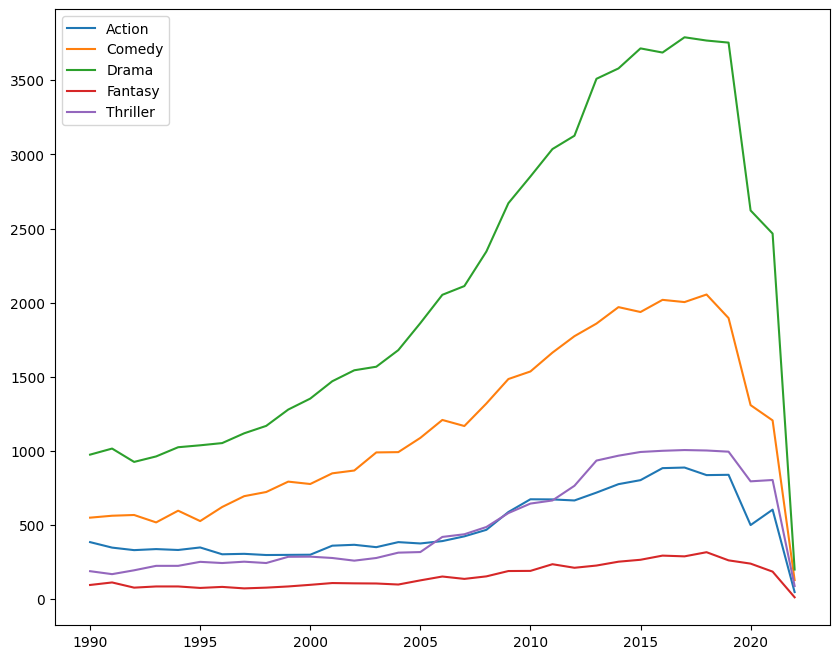

In [56]:
fig,ax=plt.subplots(1,1,figsize=(10,8))

for i in df.genre.unique():
    ax.plot(df[df.genre == i].start_year,df[df.genre == i].nMovies,label=i)
    
ax.legend()
plt.show()

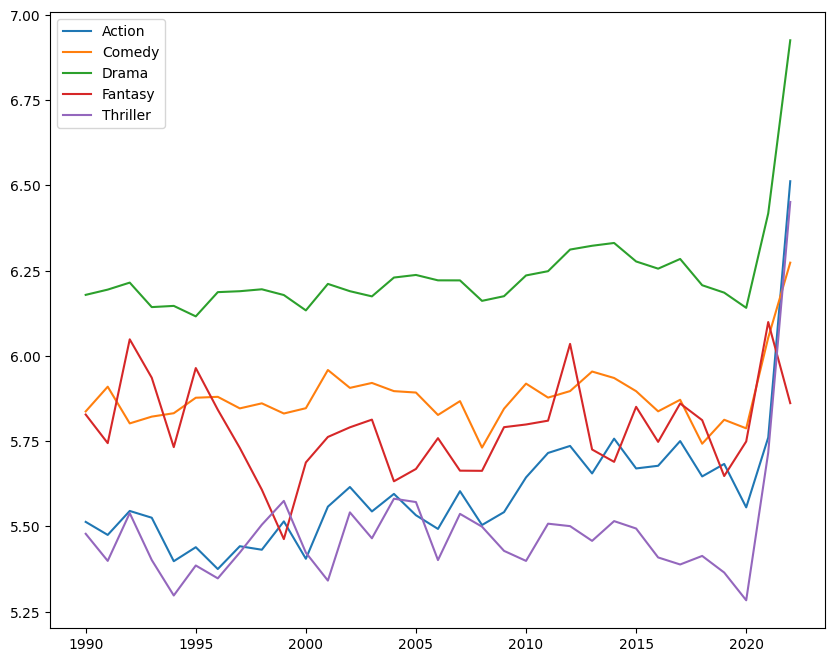

In [57]:
fig,ax=plt.subplots(1,1,figsize=(10,8))

for i in df.genre.unique():
    ax.plot(df[df.genre == i].start_year,df[df.genre == i].Rating,label=i)
    
ax.legend()
plt.show()